In [ ]:
!pip install optuna
!pip install lightgbm
!pip install boto3
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import optuna
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler,NearMiss
import pandas as pd
import numpy as np
import os
import boto3
import matplotlib.pyplot as plt
from io import BytesIO
import seaborn as sns
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,HistGradientBoostingClassifier,VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Set up AWS credentials

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = "<aws-access-key>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<secret-access-key>"
os.environ["AWS_DEFAULT_REGION"] = "<region>"

In [ ]:
# Initialize S3 client
s3_client = boto3.client('s3')

# Define S3 bucket and file path for the scaler
bucket_name = '<bucket-name>'
rb_sc_key = 'robust_scaler.pkl'  # File name and path in S3


In [ ]:
train_data=pd.read_csv('/content/MyDrive/MyDrive/credit_card_fraud_dataset/fraudTrain.csv')
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
train_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
test_data=pd.read_csv('/content/MyDrive/MyDrive/credit_card_fraud_dataset/fraudTest.csv')
test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
train_data.shape,test_data.shape

((1296675, 23), (555719, 23))

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

## Checking for null values

In [ ]:
train_data.isnull().sum()

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [ ]:
test_data.isnull().sum()

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


## Checking for duplicated values

In [ ]:
train_data.duplicated().sum(),test_data.duplicated().sum()

(np.int64(0), np.int64(0))

In [ ]:
unique={}
for col in train_data.columns:
  unique[col]=train_data[col].unique()
unique

{'Unnamed: 0': array([      0,       1,       2, ..., 1296672, 1296673, 1296674]),
 'trans_date_trans_time': array(['2019-01-01 00:00:18', '2019-01-01 00:00:44',
        '2019-01-01 00:00:51', ..., '2020-06-21 12:12:32',
        '2020-06-21 12:13:36', '2020-06-21 12:13:37'], dtype=object),
 'cc_num': array([   2703186189652095,        630423337322,      38859492057661,
           3534093764340240,     375534208663984,    4767265376804500,
             30074693890476,    6011360759745864,    4922710831011201,
           2720830304681674,       4642894980163,     377234009633447,
            180042946491150,    5559857416065248,    3514865930894695,
           6011999606625827,    6011860238257910,    3565423334076143,
           2348245054386329, 4956828990005111019, 4469777115158234880,
           2305336922781618,     180048185037117,        630441765090,
        4428780983793657331,     343464013864032,     374930071163758,
           4334230547694630, 4225990116481262579,    4260059

## Drop unwanted columns

In [ ]:
train_data.drop(['Unnamed: 0','cc_num','zip','first','last','street','job','dob','trans_num'],axis=1,inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   city                   1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   lat                    1296675 non-null  float64
 8   long                   1296675 non-null  float64
 9   city_pop               1296675 non-null  int64  
 10  unix_time              1296675 non-null  int64  
 11  merch_lat              1296675 non-null  float64
 12  merch_long             1296675 non-null  float64
 13  is_fraud               1296675 non-null  int64  
dtypes: float64(5), int

In [ ]:
unique={}
for col in train_data.columns:
  unique[col]=train_data[col].unique()
unique


{'trans_date_trans_time': array(['2019-01-01 00:00:18', '2019-01-01 00:00:44',
        '2019-01-01 00:00:51', ..., '2020-06-21 12:12:32',
        '2020-06-21 12:13:36', '2020-06-21 12:13:37'], dtype=object),
 'merchant': array(['fraud_Rippin, Kub and Mann', 'fraud_Heller, Gutmann and Zieme',
        'fraud_Lind-Buckridge', 'fraud_Kutch, Hermiston and Farrell',
        'fraud_Keeling-Crist', 'fraud_Stroman, Hudson and Erdman',
        'fraud_Rowe-Vandervort', 'fraud_Corwin-Collins',
        'fraud_Herzog Ltd', 'fraud_Schoen, Kuphal and Nitzsche',
        'fraud_Rutherford-Mertz', 'fraud_Kerluke-Abshire',
        'fraud_Lockman Ltd', 'fraud_Kiehn Inc', 'fraud_Beier-Hyatt',
        'fraud_Schmidt and Sons', 'fraud_Lebsack and Sons',
        'fraud_Mayert Group', 'fraud_Konopelski, Schneider and Hartmann',
        'fraud_Schultz, Simonis and Little', 'fraud_Bauch-Raynor',
        'fraud_Harris Inc', 'fraud_Kling-Grant', 'fraud_Pacocha-Bauch',
        'fraud_Lesch Ltd', 'fraud_Kunde-Sanford

## Convert the date columns to timestamp

In [ ]:
train_data['trans_date_trans_time']=pd.to_datetime(train_data['trans_date_trans_time'])
#test_data['trans_date_trans_time']=pd.to_datetime(test_data['trans_date_trans_time'])

## Converting unix_time into human readable format

In [ ]:
train_data['unix_time']=pd.to_datetime(train_data['unix_time'],unit='s')
#test_data['unix_time']=pd.to_datetime(test_data['unix_time'],unit='s')

In [ ]:
train_data.dtypes

,0
transaction_time,datetime64[ns]
merchant,object
category,object
amt,float64
gender,object
city,object
state,object
lat,float64
long,float64
city_pop,int64


In [ ]:
train_data=train_data.rename(columns={'trans_date_trans_time':'transaction_time'})
#test_data=test_data.rename(columns={'trans_date_trans_time':'transaction_time'})

In [ ]:
train_data.columns

Index(['transaction_time', 'merchant', 'category', 'amt', 'gender', 'city',
       'state', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

## Separating the datetime object into year, month, day, minutes and seconds

In [ ]:
train_data['transaction_time_year']=train_data['transaction_time'].dt.year
train_data['transaction_time_month']=train_data['transaction_time'].dt.month
train_data['transaction_time_day']=train_data['transaction_time'].dt.day
train_data['transaction_time_hour']=train_data['transaction_time'].dt.hour
train_data['transaction_time_min']=train_data['transaction_time'].dt.minute
train_data['transaction_time_sec']=train_data['transaction_time'].dt.second

In [ ]:
'''test_data['transaction_time_year']=test_data['transaction_time'].dt.year
test_data['transaction_time_month']=test_data['transaction_time'].dt.month
test_data['transaction_time_day']=test_data['transaction_time'].dt.day
test_data['transaction_time_hour']=test_data['transaction_time'].dt.hour
test_data['transaction_time_min']=test_data['transaction_time'].dt.minute
test_data['transaction_time_sec']=test_data['transaction_time'].dt.second'''

In [ ]:
train_data[['transaction_time_year','transaction_time_month','transaction_time_day','transaction_time_hour',
            'transaction_time_min','transaction_time_sec']].head()

,transaction_time_year,transaction_time_month,transaction_time_day,transaction_time_hour,transaction_time_min,transaction_time_sec
0,2019,1,1,0,0,18
1,2019,1,1,0,0,44
2,2019,1,1,0,0,51
3,2019,1,1,0,1,16
4,2019,1,1,0,3,6


In [ ]:
'''test_data[['transaction_time_year','transaction_time_month','transaction_time_day','transaction_time_hour',
            'transaction_time_min','transaction_time_sec']].head()'''

,transaction_time_year,transaction_time_month,transaction_time_day,transaction_time_hour,transaction_time_min,transaction_time_sec
0,2020,6,21,12,14,25
1,2020,6,21,12,14,33
2,2020,6,21,12,14,53
3,2020,6,21,12,15,15
4,2020,6,21,12,15,17


In [ ]:
train_data['unix_time'].head()

,unix_time
0,2012-01-01 00:00:18
1,2012-01-01 00:00:44
2,2012-01-01 00:00:51
3,2012-01-01 00:01:16
4,2012-01-01 00:03:06


In [ ]:
train_data['unix_time_year']=train_data['unix_time'].dt.year
train_data['unix_time_month']=train_data['unix_time'].dt.month
train_data['unix_time_day']=train_data['unix_time'].dt.day
train_data['unix_time_hour']=train_data['unix_time'].dt.hour
train_data['unix_time_min']=train_data['unix_time'].dt.minute
train_data['unix_time_sec']=train_data['unix_time'].dt.second

In [ ]:
'''test_data['unix_time_year']=test_data['unix_time'].dt.year
test_data['unix_time_month']=test_data['unix_time'].dt.month
test_data['unix_time_day']=test_data['unix_time'].dt.day
test_data['unix_time_hour']=test_data['unix_time'].dt.hour
test_data['unix_time_min']=test_data['unix_time'].dt.minute
test_data['unix_time_sec']=test_data['unix_time'].dt.second'''

In [ ]:
train_data[['unix_time_year','unix_time_month','unix_time_day','unix_time_hour',
            'unix_time_min','unix_time_sec']].head()

,unix_time_year,unix_time_month,unix_time_day,unix_time_hour,unix_time_min,unix_time_sec
0,2012,1,1,0,0,18
1,2012,1,1,0,0,44
2,2012,1,1,0,0,51
3,2012,1,1,0,1,16
4,2012,1,1,0,3,6


In [ ]:
'''test_data[['unix_time_year','unix_time_month','unix_time_day','unix_time_hour',
            'unix_time_min','unix_time_sec']].head()'''

,unix_time_year,unix_time_month,unix_time_day,unix_time_hour,unix_time_min,unix_time_sec
0,2013,6,21,12,14,25
1,2013,6,21,12,14,33
2,2013,6,21,12,14,53
3,2013,6,21,12,15,15
4,2013,6,21,12,15,17


In [ ]:
train_data['transaction_time_year'].unique(),train_data['unix_time_year'].unique()

(array([2019, 2020], dtype=int32), array([2012, 2013], dtype=int32))

* `transaction_time_year` should be the more accurate representation of the year the transaction took place.
* `unix_time_year` might have been incorrectly parsed or mapped. It could be reflecting the year when the Unix timestamp was generated or stored, which doesn't always align with the actual year of the transaction.

In [ ]:
train_data.drop(['transaction_time','unix_time'],axis=1,inplace=True)
#test_data.drop(['transaction_time','unix_time'],axis=1,inplace=True)

In [ ]:
train_data.drop(
    train_data.filter(regex='^unix_time').columns,axis=1,inplace=True
)

In [ ]:
'''test_data.drop(
    test_data.filter(regex='^unix_time').columns,axis=1,inplace=True
)'''

## Understanding the data by plotting visuals

## Total number of frauds and non_frauds happend

In [ ]:
train_data['is_fraud'].value_counts()

,count
is_fraud,
0,1289169
1,7506


In [ ]:
train_data['is_fraud'].value_counts()/train_data.shape[0]*100

,count
is_fraud,
0,99.421135
1,0.578865


In [ ]:
test_data['is_fraud'].value_counts()

,count
is_fraud,
0,553574
1,2145


In [ ]:
test_data['is_fraud'].value_counts()/test_data.shape[0]*100

,count
is_fraud,
0,99.614014
1,0.385986


[]

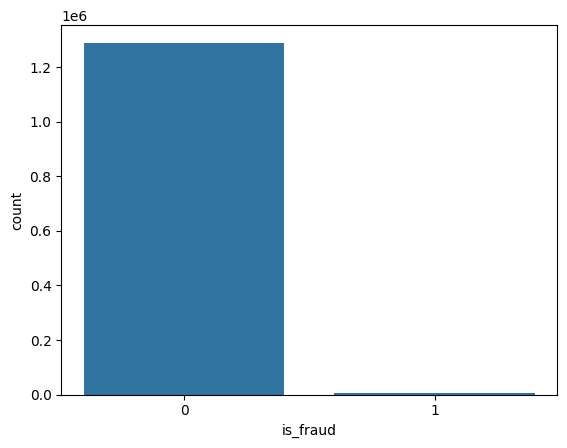

In [ ]:
sns.countplot(x='is_fraud',data=train_data)
plt.plot()

## Yearly Trend of Fraudulent vs Non-Fraudulent Transactions

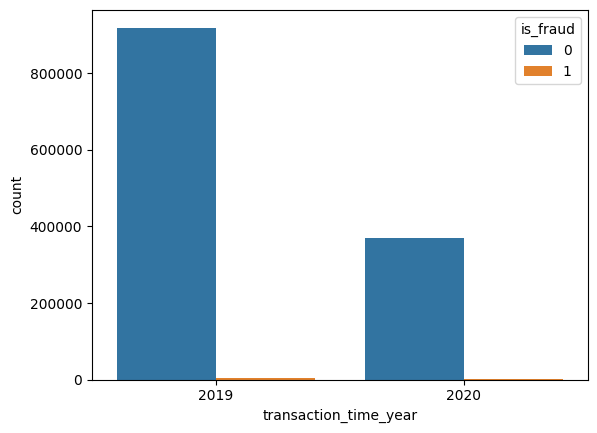

In [ ]:
grouped_data = train_data.groupby(['transaction_time_year', 'is_fraud'])['is_fraud'].count().reset_index(name='count')
sns.barplot(x='transaction_time_year', y='count', hue='is_fraud', data=grouped_data)
plt.show()

## Monthly Trend of fraud and non-fraud transactions

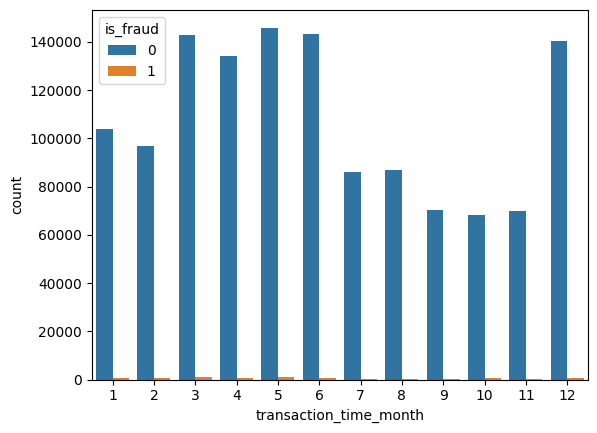

In [ ]:
grouped_data = train_data.groupby(['transaction_time_month', 'is_fraud'])['is_fraud'].count().reset_index(name='count')
sns.barplot(x='transaction_time_month', y='count', hue='is_fraud', data=grouped_data)
plt.show()

## How many fraudulent and non-fraudulent transactions happened each day

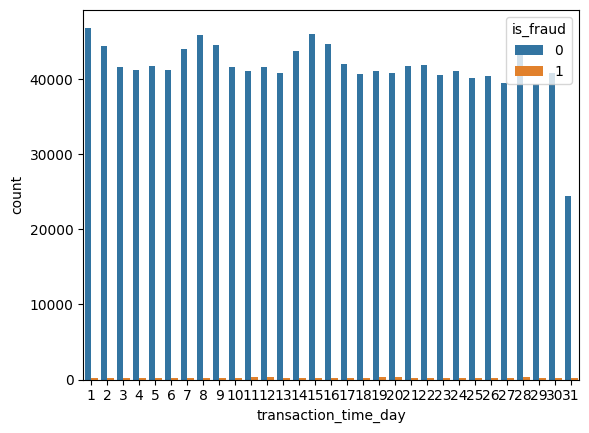

In [ ]:
grouped_data = train_data.groupby(['transaction_time_day', 'is_fraud'])['is_fraud'].count().reset_index(name='count')
sns.barplot(x='transaction_time_day', y='count', hue='is_fraud', data=grouped_data)
plt.show()

## Merchent with most amount of frauds

In [ ]:
train_data[train_data['is_fraud']==1].groupby('merchant')['is_fraud'].value_counts().sort_values(ascending=False).head(10)

,,count
merchant,is_fraud,
fraud_Rau and Sons,1,49
fraud_Kozey-Boehm,1,48
fraud_Cormier LLC,1,48
fraud_Doyle Ltd,1,47
fraud_Vandervort-Funk,1,47
fraud_Kilback LLC,1,47
fraud_Padberg-Welch,1,44
fraud_Kuhn LLC,1,44
fraud_Terry-Huel,1,43


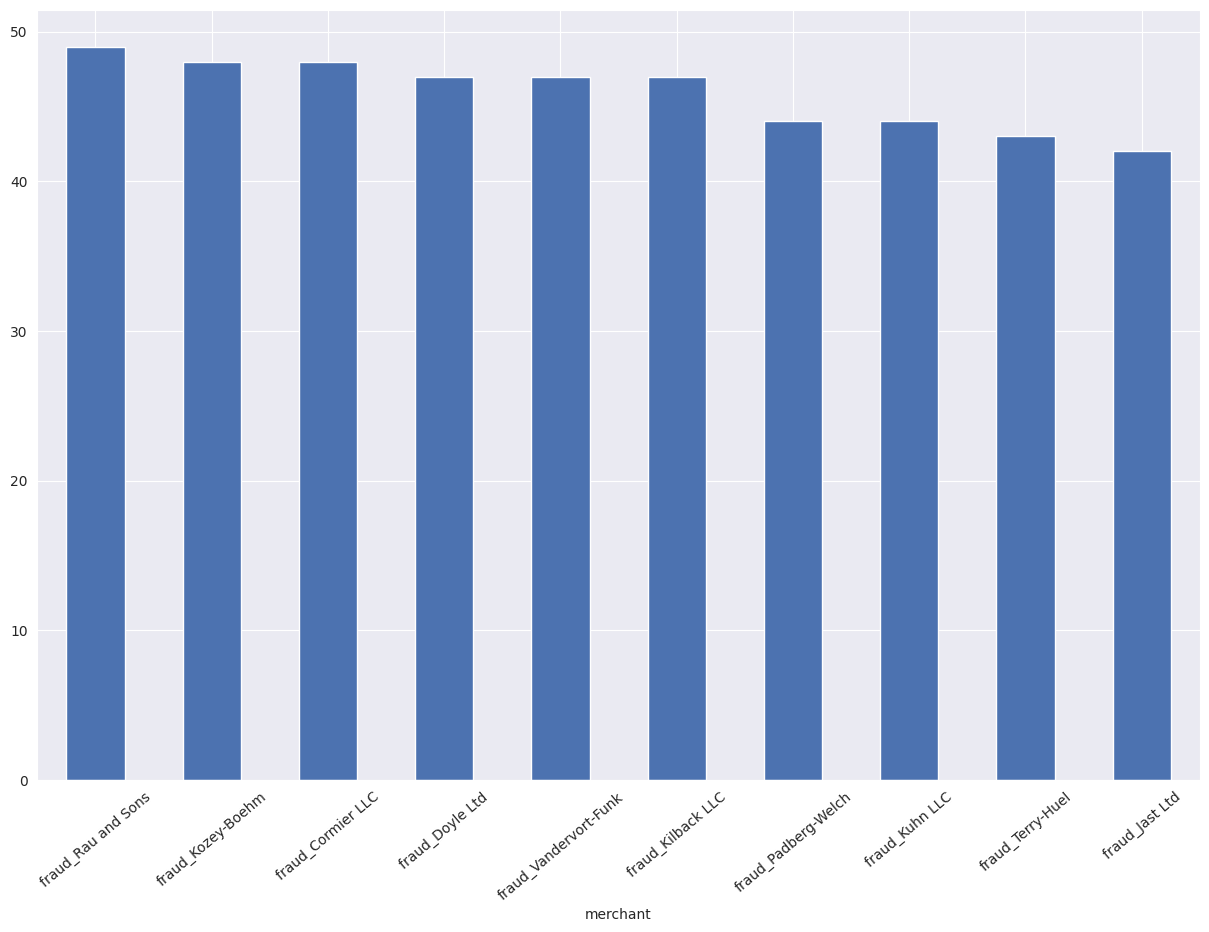

In [ ]:
train_data[train_data['is_fraud']==1].groupby('merchant')['is_fraud'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

## Merchant with least amount of fraud

In [ ]:
train_data[train_data['is_fraud']==1].groupby('merchant')['is_fraud'].count().sort_values().head(10)

,is_fraud
merchant,
fraud_Dicki Ltd,1
fraud_Tillman LLC,1
fraud_Thiel Ltd,1
fraud_Jerde-Hermann,1
"fraud_Prosacco, Kreiger and Kovacek",1
fraud_Bednar Inc,1
"fraud_Stokes, Christiansen and Sipes",1
fraud_Johnston-Casper,1
fraud_Dietrich-Fadel,1


In [ ]:
merchant_col=[i.split(',') for i in train_data['merchant']]
merchant_df=pd.DataFrame(merchant_col,columns=['merchant_business','merchant_name'])
merchant_df

,merchant_business,merchant_name
0,fraud_Rippin,Kub and Mann
1,fraud_Heller,Gutmann and Zieme
2,fraud_Lind-Buckridge,None
3,fraud_Kutch,Hermiston and Farrell
4,fraud_Keeling-Crist,None
...,...,...
1296670,fraud_Reichel Inc,None
1296671,fraud_Abernathy and Sons,None
1296672,fraud_Stiedemann Ltd,None
1296673,fraud_Reinger,Weissnat and Strosin


In [ ]:
len(merchant_df['merchant_business'].unique())

648

In [ ]:
train_data=train_data.join(merchant_df)
train_data

,merchant,category,amt,gender,city,state,lat,long,city_pop,merch_lat,merch_long,is_fraud,transaction_time_year,transaction_time_month,transaction_time_day,transaction_time_hour,transaction_time_min,transaction_time_sec,merchant_business,merchant_name
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,36.011293,-82.048315,0,2019,1,1,0,0,18,fraud_Rippin,Kub and Mann
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,49.159047,-118.186462,0,2019,1,1,0,0,44,fraud_Heller,Gutmann and Zieme
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,43.150704,-112.154481,0,2019,1,1,0,0,51,fraud_Lind-Buckridge,None
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,47.034331,-112.561071,0,2019,1,1,0,1,16,fraud_Kutch,Hermiston and Farrell
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,38.674999,-78.632459,0,2019,1,1,0,3,6,fraud_Keeling-Crist,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,Hatch,UT,37.7175,-112.4777,258,36.841266,-111.690765,0,2020,6,21,12,12,8,fraud_Reichel Inc,None
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,Tuscarora,MD,39.2667,-77.5101,100,38.906881,-78.246528,0,2020,6,21,12,12,19,fraud_Abernathy and Sons,None
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,High Rolls Mountain Park,NM,32.9396,-105.8189,899,33.619513,-105.130529,0,2020,6,21,12,12,32,fraud_Stiedemann Ltd,None
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,Manderson,SD,43.3526,-102.5411,1126,42.788940,-103.241160,0,2020,6,21,12,13,36,fraud_Reinger,Weissnat and Strosin


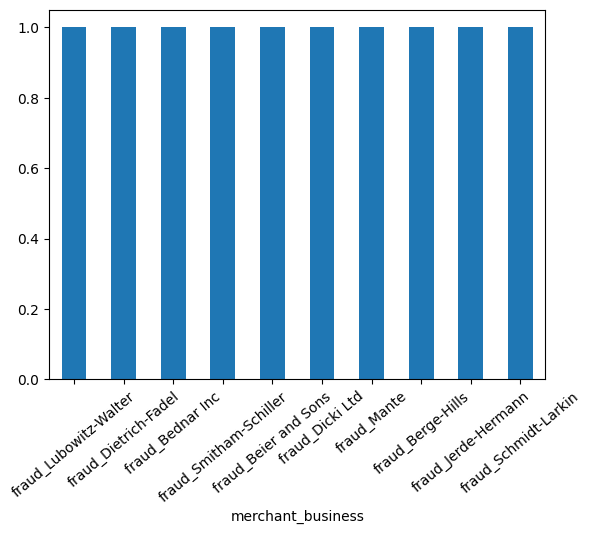

In [ ]:
train_data[train_data['is_fraud']==1].groupby('merchant_business')['is_fraud'].size().sort_values().head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

## Merchant with least amount of non_frauds

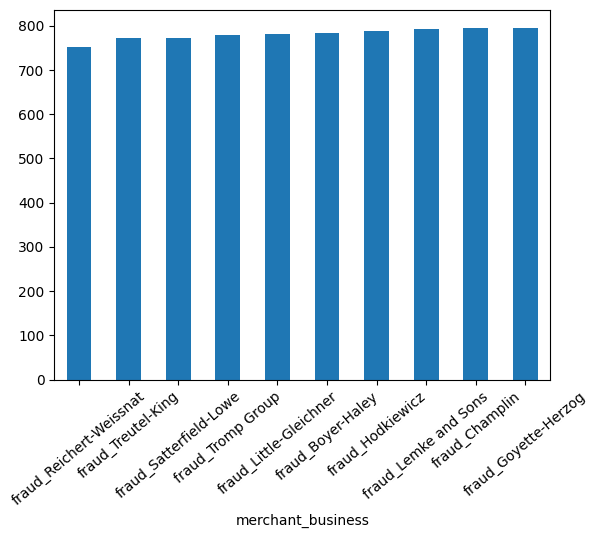

In [ ]:
train_data[train_data['is_fraud']==0].groupby('merchant_business')['is_fraud'].count().sort_values().head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby(['state','merchant_business'])['is_fraud'].count().sort_values(ascending=False).head(10).reset_index()
grouped_data

,state,merchant_business,is_fraud
0,TX,fraud_Mosciski,8
1,NY,fraud_Doyle Ltd,8
2,PA,fraud_Boyer-Reichert,7
3,OR,fraud_Kerluke-Abshire,7
4,MI,fraud_Reichert,7
5,NY,fraud_McDermott-Weimann,7
6,NY,fraud_Reichert,7
7,CA,fraud_McDermott-Weimann,6
8,PA,fraud_Mosciski,6
9,TX,fraud_Fisher-Schowalter,6


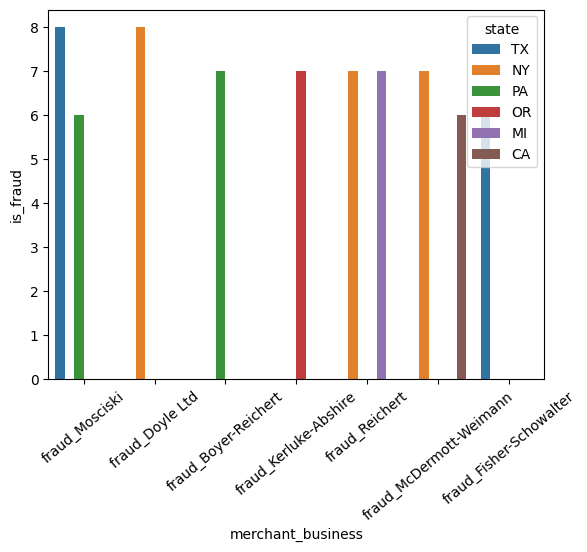

In [ ]:
sns.barplot(x='merchant_business',y='is_fraud',hue='state',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

In [ ]:
top_10_merchants=train_data[['merchant_business','merch_lat']].value_counts().head(10).reset_index()
top_10_merchants

,merchant_business,merch_lat,count
0,fraud_Cronin,41.711206,2
1,fraud_Stark-Koss,36.013521,2
2,fraud_Moore,44.274781,2
3,fraud_Streich Ltd,35.659507,2
4,fraud_Kuhic Inc,40.743976,2
5,fraud_Tillman,41.365947,2
6,fraud_Stracke-Lemke,40.782456,2
7,fraud_Huels-Hahn,32.960482,2
8,fraud_DuBuque LLC,32.290020,2
9,fraud_Gutmann-Upton,44.035717,2


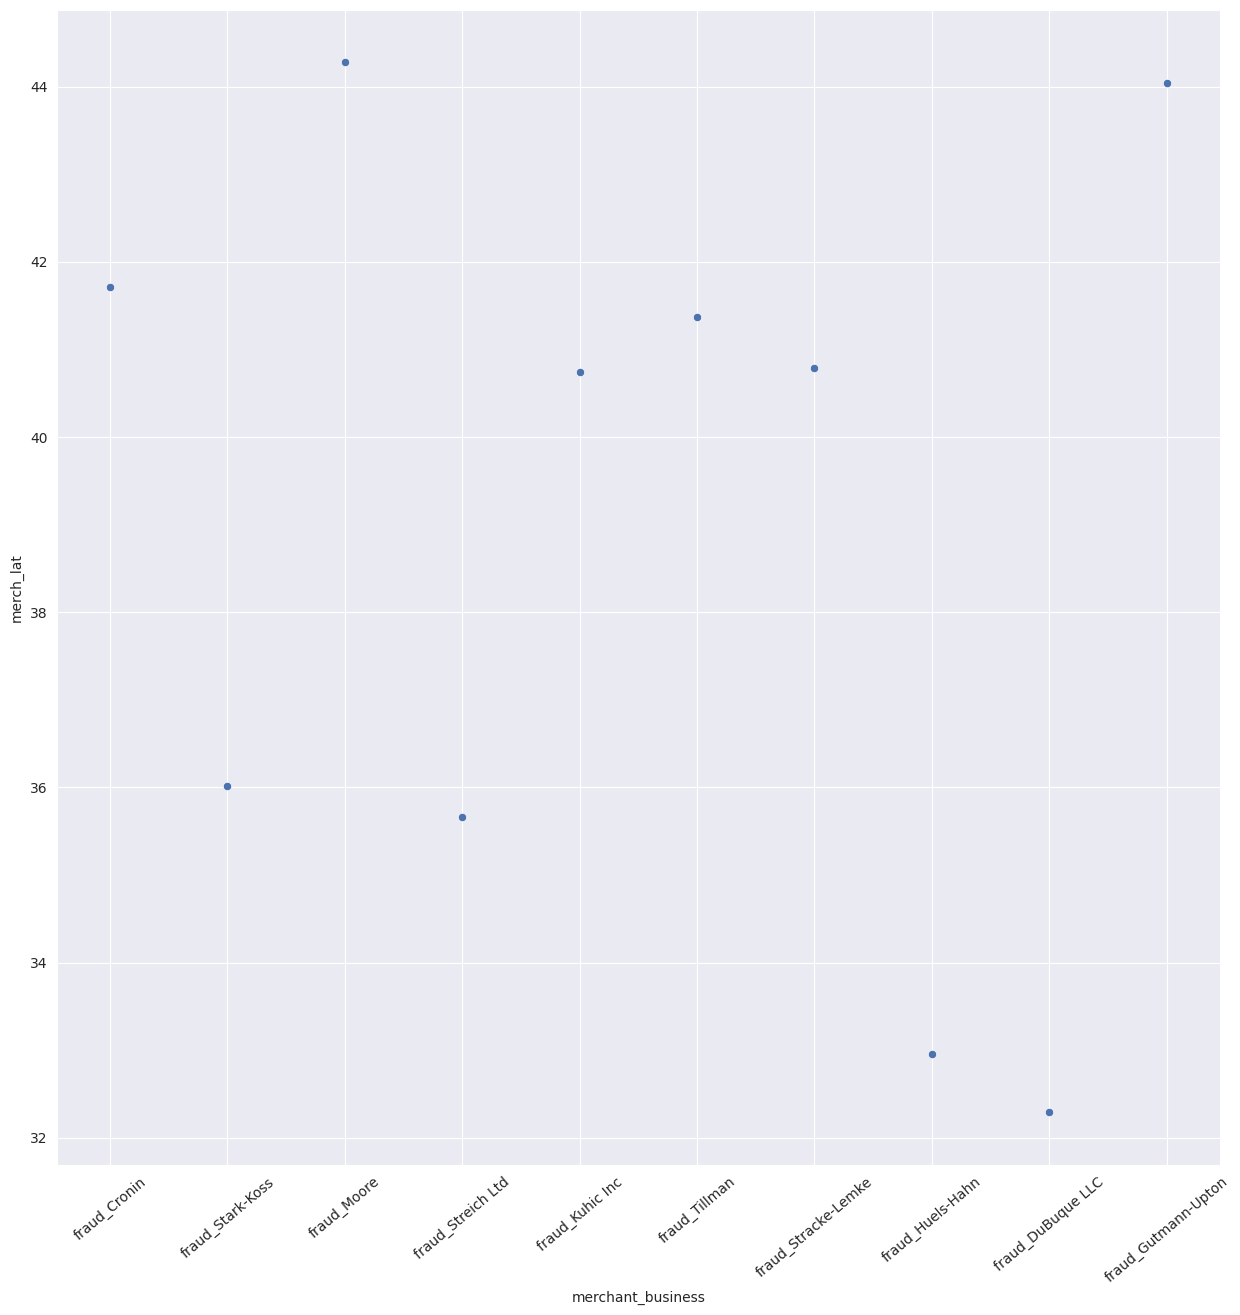

In [ ]:
sns.set({'figure.figsize':(15,15)})
sns.scatterplot(x='merchant_business',y='merch_lat',data=top_10_merchants)
plt.xticks(rotation=40)
plt.show()

In [ ]:
merchants_10=train_data[['merchant_business','merch_long']].value_counts().head(10).reset_index()
merchants_10

,merchant_business,merch_long,count
0,fraud_Streich,-81.430240,2
1,fraud_Block Group,-74.646757,2
2,fraud_Osinski,-97.335552,2
3,fraud_Casper,-78.916239,2
4,fraud_Jakubowski Group,-82.390676,2
5,fraud_Goodwin-Nitzsche,-79.646313,2
6,fraud_Rowe,-90.233380,2
7,fraud_Klocko,-89.592468,2
8,fraud_Barton Inc,-79.123472,2
9,fraud_Beier-Hyatt,-82.177743,2


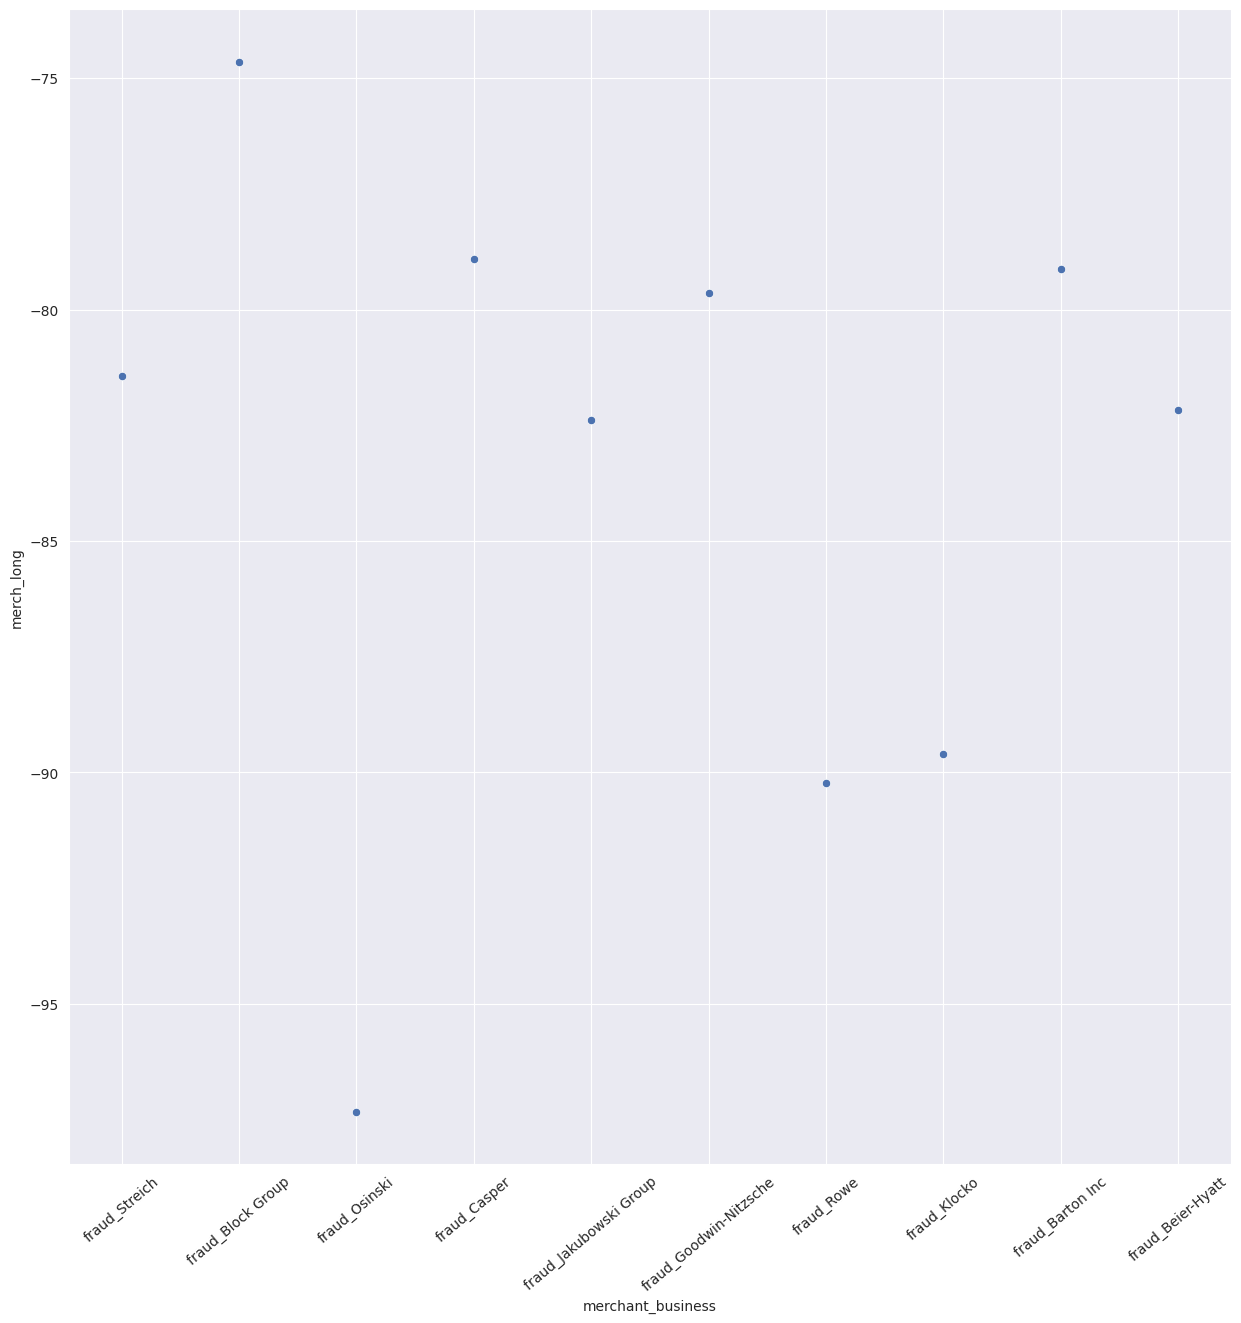

In [ ]:
sns.set({'figure.figsize':(15,15)})
sns.scatterplot(x='merchant_business',y='merch_long',data=merchants_10)
plt.xticks(rotation=40)
plt.show()

## how much amount was fraud and non-fraud

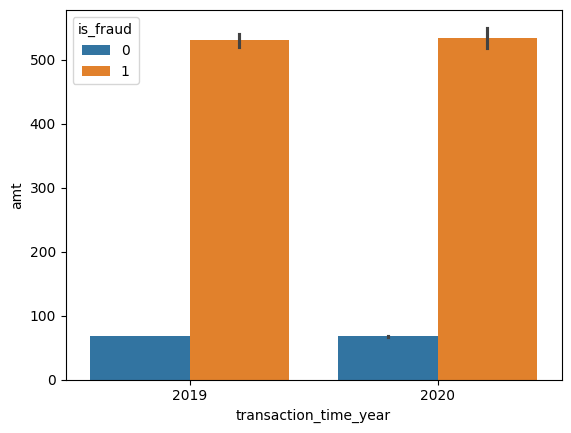

In [ ]:
sns.barplot(y='amt',x='transaction_time_year',hue='is_fraud',data=train_data)
plt.show()

In [ ]:
train_data['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

In [ ]:
train_data.groupby('category')['is_fraud'].value_counts().sort_values(ascending=False)

,,count
category,is_fraud,
gas_transport,0,131041
home,0,122917
grocery_pos,0,121895
shopping_pos,0,115829
kids_pets,0,112796
shopping_net,0,95830
entertainment,0,93781
food_dining,0,91310
personal_care,0,90538


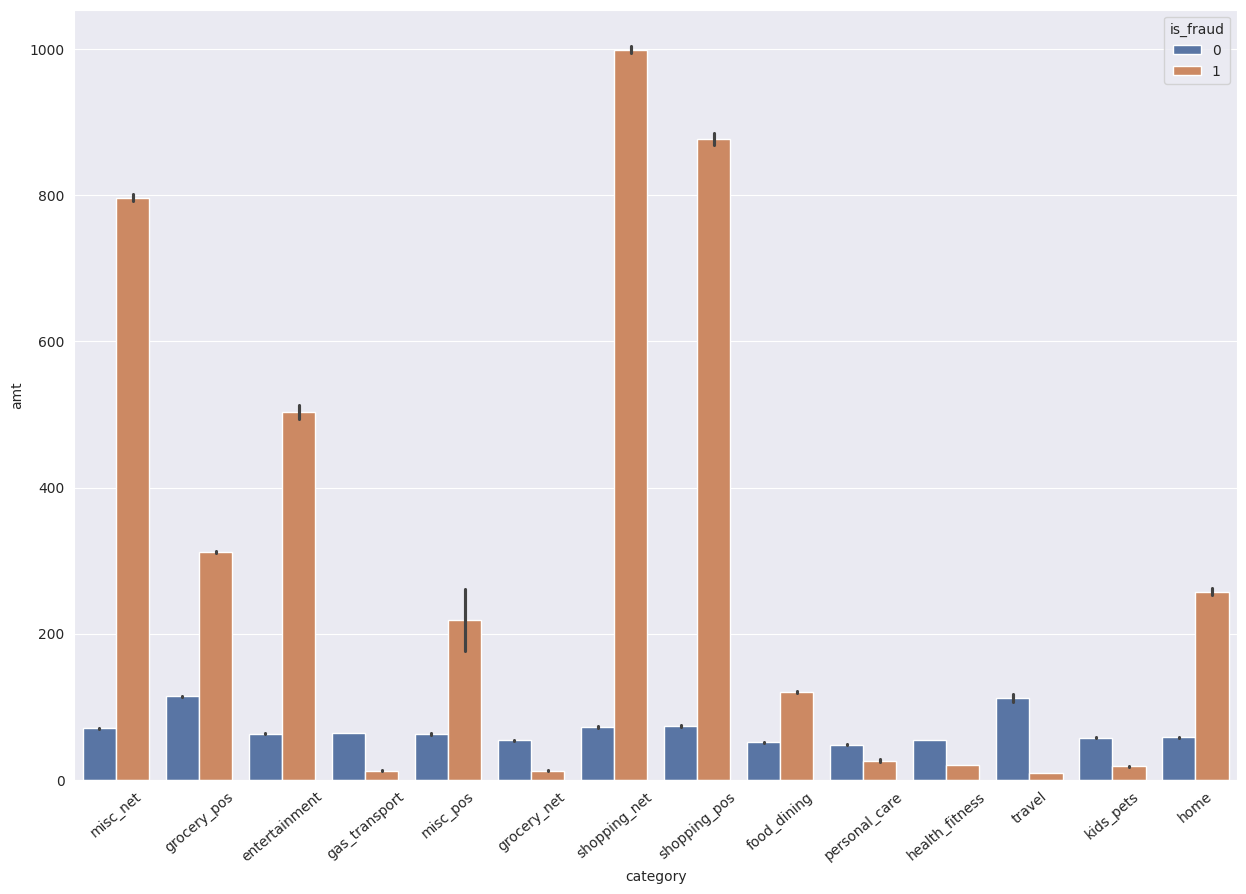

In [ ]:
sns.set({'figure.figsize':(15,10)})
sns.barplot(x='category',y='amt',hue='is_fraud',data=train_data)
plt.xticks(rotation=40)
plt.show()

## Fraudent cases according to gender

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby('gender')['is_fraud'].count().reset_index(name='count').sort_values(by='count').head(10)
grouped_data

,gender,count
0,F,3735
1,M,3771


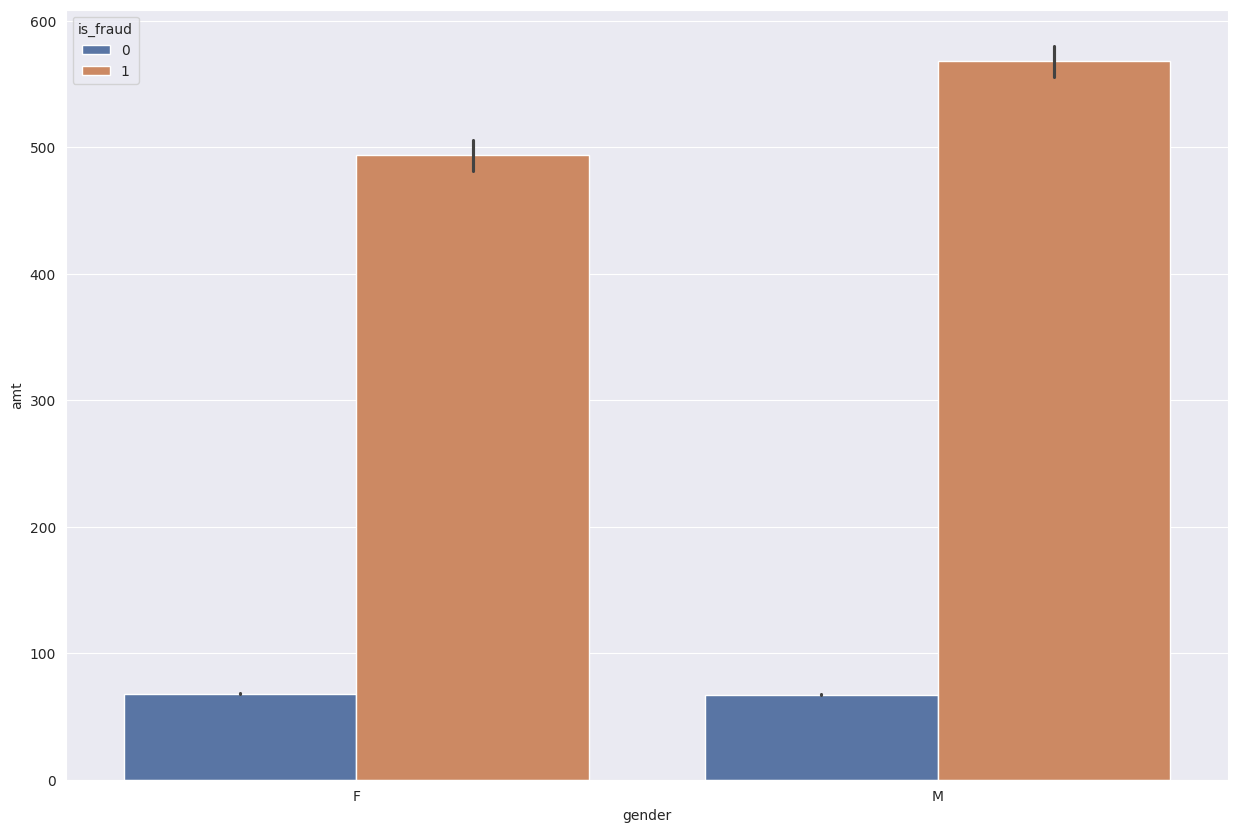

In [ ]:
sns.barplot(x='gender',y='amt',data=grouped_data)
plt.show()

## top 10 cities with most number of frauds

In [ ]:
train_data[train_data['is_fraud']==1].groupby('city')['is_fraud'].value_counts().sort_values(ascending=False).head(10)

,,count
city,is_fraud,
Houston,1,39
Warren,1,33
Naples,1,29
Huntsville,1,29
Topeka,1,27
Tulsa,1,27
Dallas,1,27
Detroit,1,26
Randolph,1,25


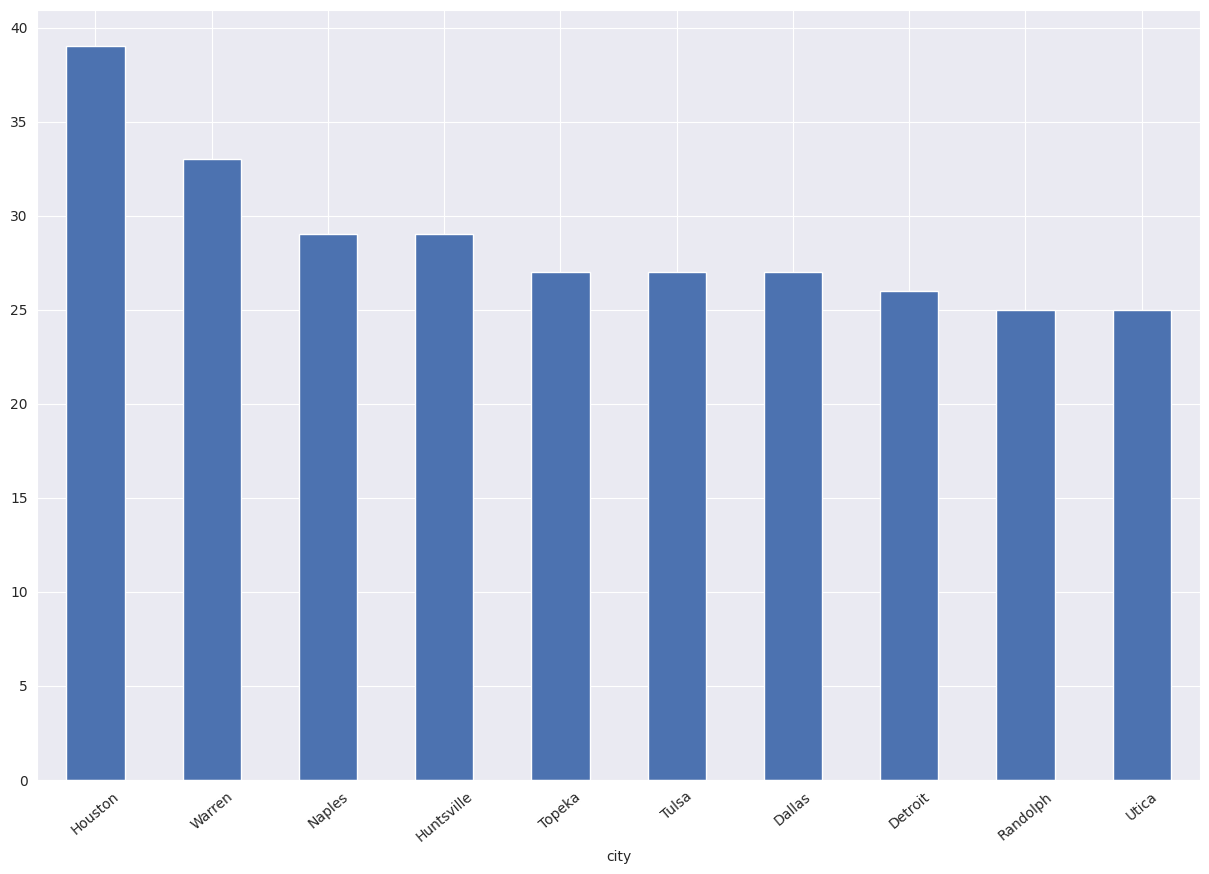

In [ ]:
train_data[train_data['is_fraud']==1].groupby('city')['is_fraud'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with fraud and non-fraud transactions

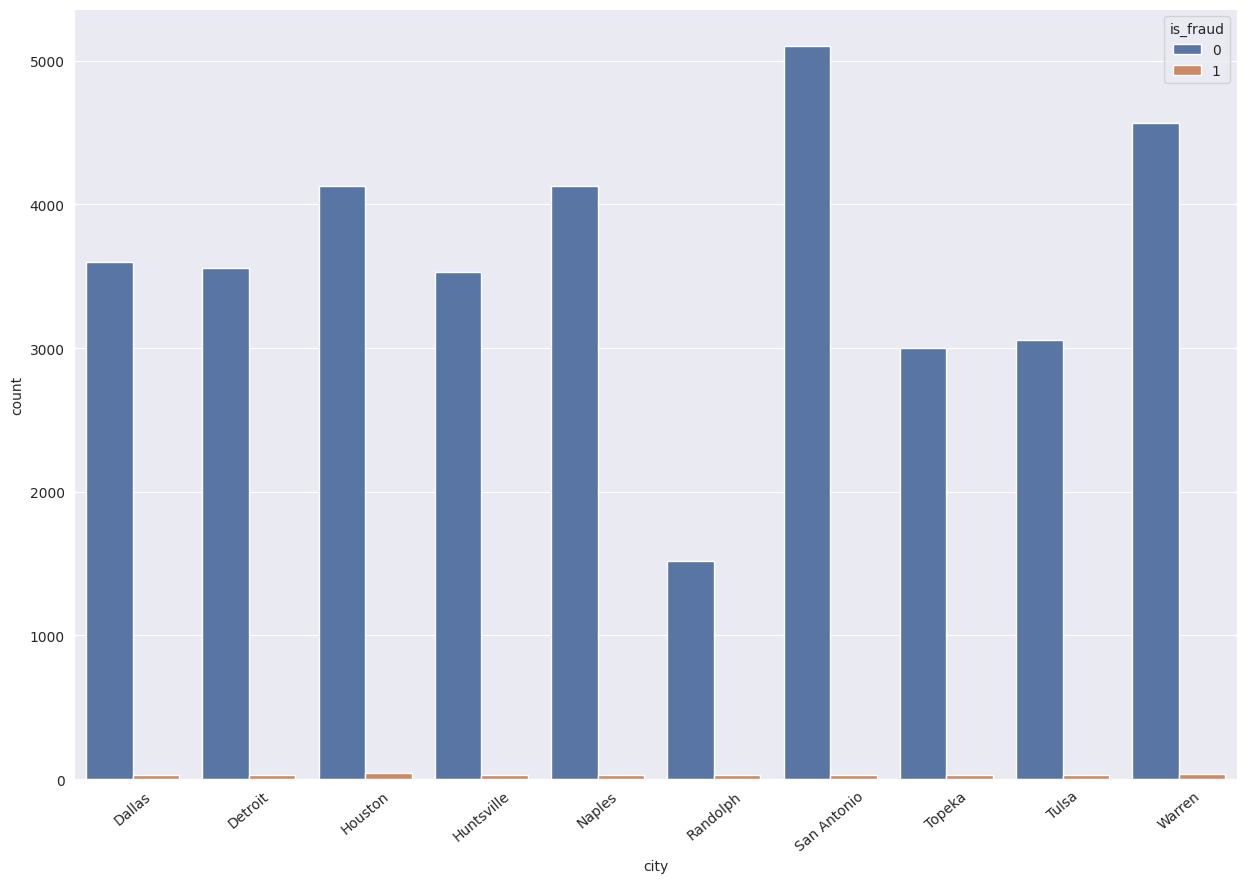

In [ ]:
top_cities=train_data[(train_data['is_fraud'] == 1)].groupby('city').size().nlargest(10).index
filtered_data=train_data[train_data['city'].isin(top_cities)]

grouped_data=filtered_data.groupby(['city','is_fraud']).size().reset_index(name='count')

sns.barplot(x='city',y='count',hue='is_fraud',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with least amount of non fraud transactions

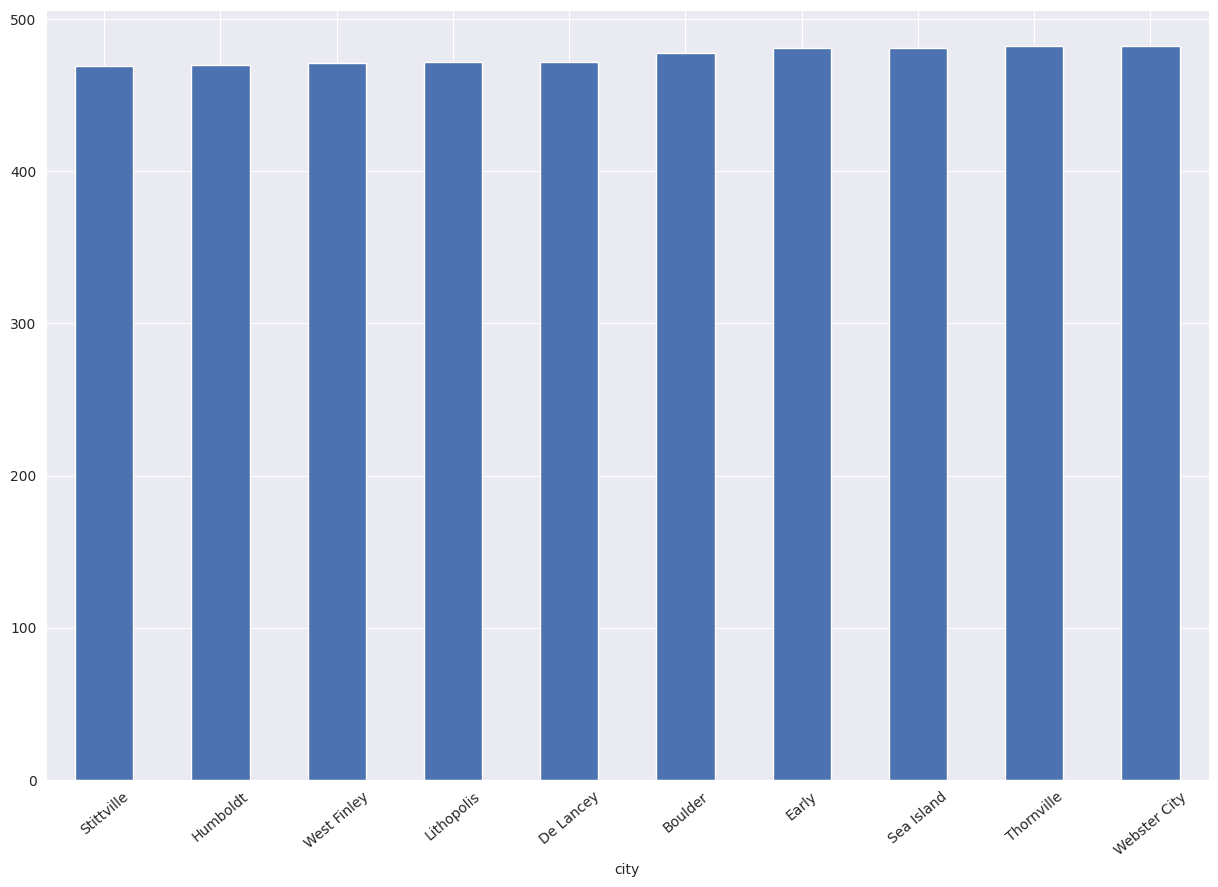

In [ ]:
train_data[train_data['is_fraud']==0].groupby('city')['is_fraud'].count().sort_values().head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with most frauds

In [ ]:
train_data[train_data['is_fraud']==1].groupby(['state','is_fraud'])['is_fraud'].count().sort_values(ascending=False).head(10)

,,is_fraud
state,is_fraud,
NY,1,555
TX,1,479
PA,1,458
CA,1,326
OH,1,321
FL,1,281
IL,1,248
MI,1,238
AL,1,215


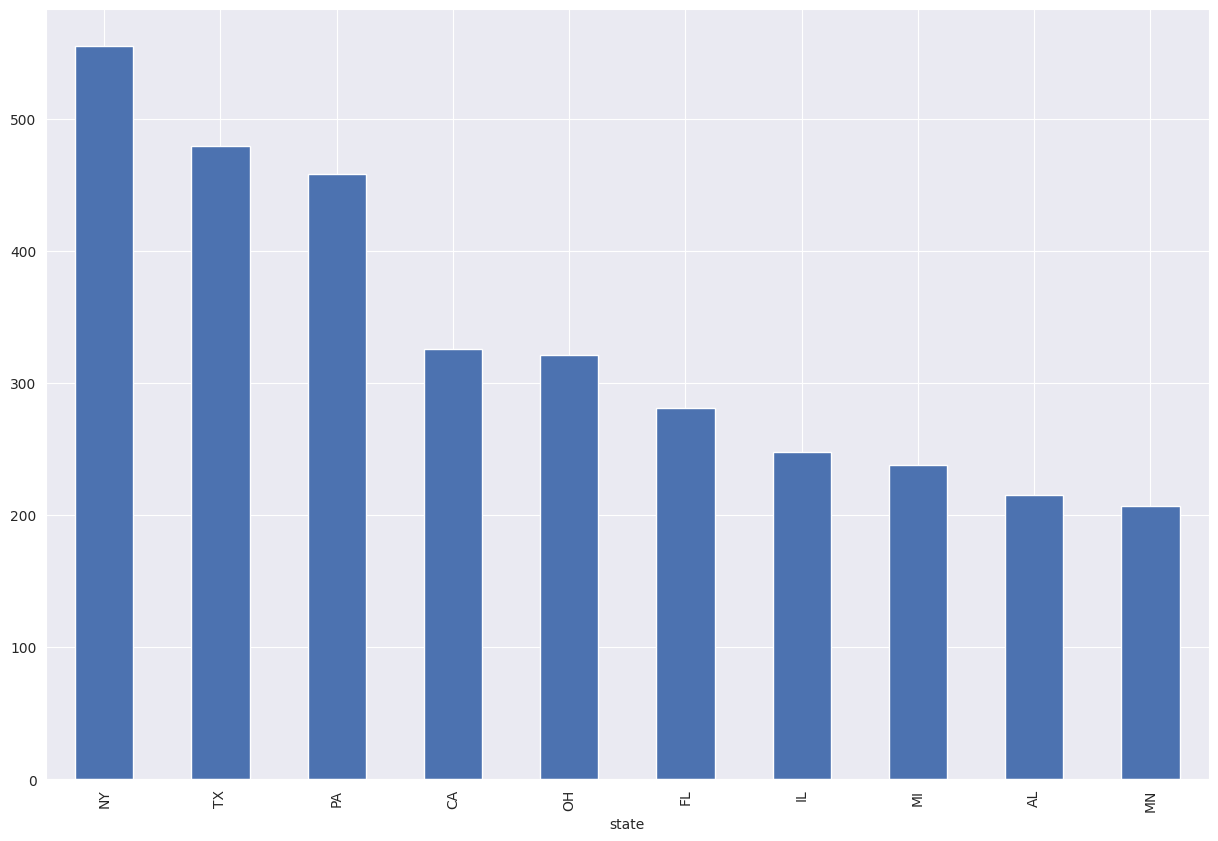

In [ ]:
train_data[train_data['is_fraud']==1].groupby('state')['is_fraud'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

## Top 10 states with least amount of frauds

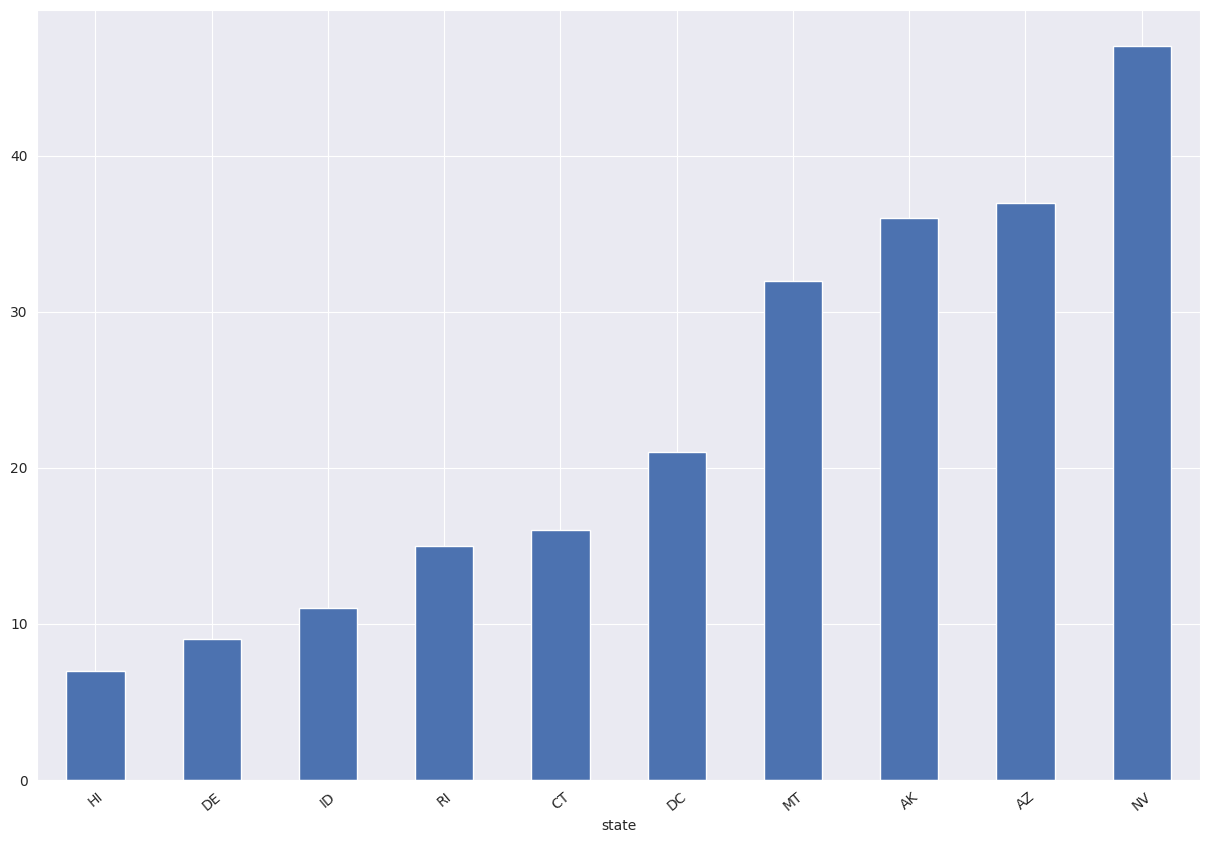

In [ ]:
train_data[train_data['is_fraud']==1].groupby('state')['is_fraud'].count().sort_values().head(10).plot(kind='bar')
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with least amount of frauds state wise

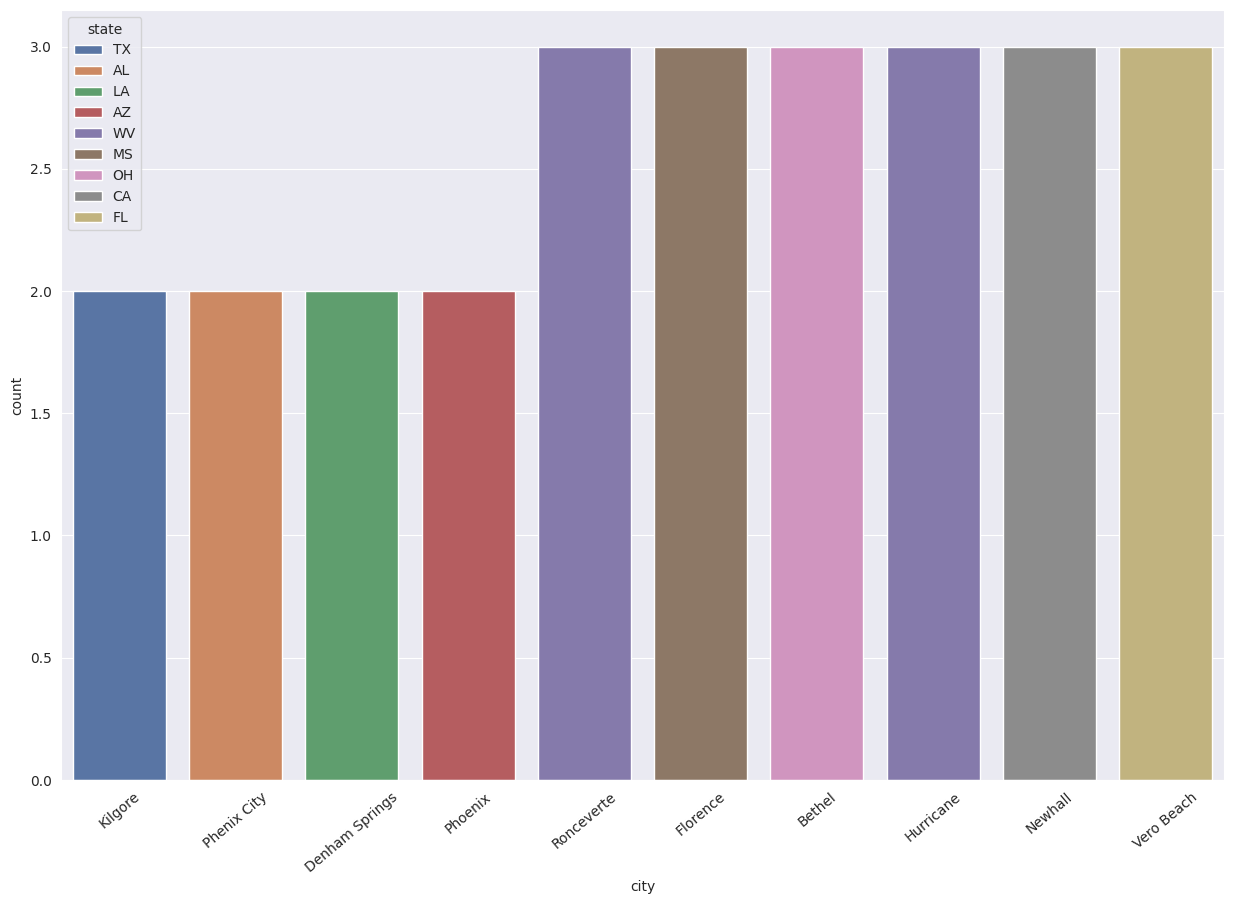

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby(['state','city'])['is_fraud'].count().reset_index(name='count').sort_values(by='count').head(10)
sns.barplot(x='city',y='count',hue='state',data=pd.DataFrame(grouped_data))
plt.xticks(rotation=40)
plt.show()

In [ ]:
train_data['zip'].head()

,zip
0,28654
1,99160
2,83252
3,59632
4,24433


## Top 10 State-City combinations with least amount of frauds

In [ ]:
train_data[train_data['is_fraud']==1].groupby(['state','city'])['is_fraud'].count().reset_index(name='count').sort_values(by='count').head(10)


,state,city,count
619,TX,Kilgore,2
18,AL,Phenix City,2
215,LA,Denham Springs,2
41,AZ,Phoenix,2
707,WV,Ronceverte,3
322,MS,Florence,3
460,OH,Bethel,3
704,WV,Hurricane,3
63,CA,Newhall,3
114,FL,Vero Beach,3


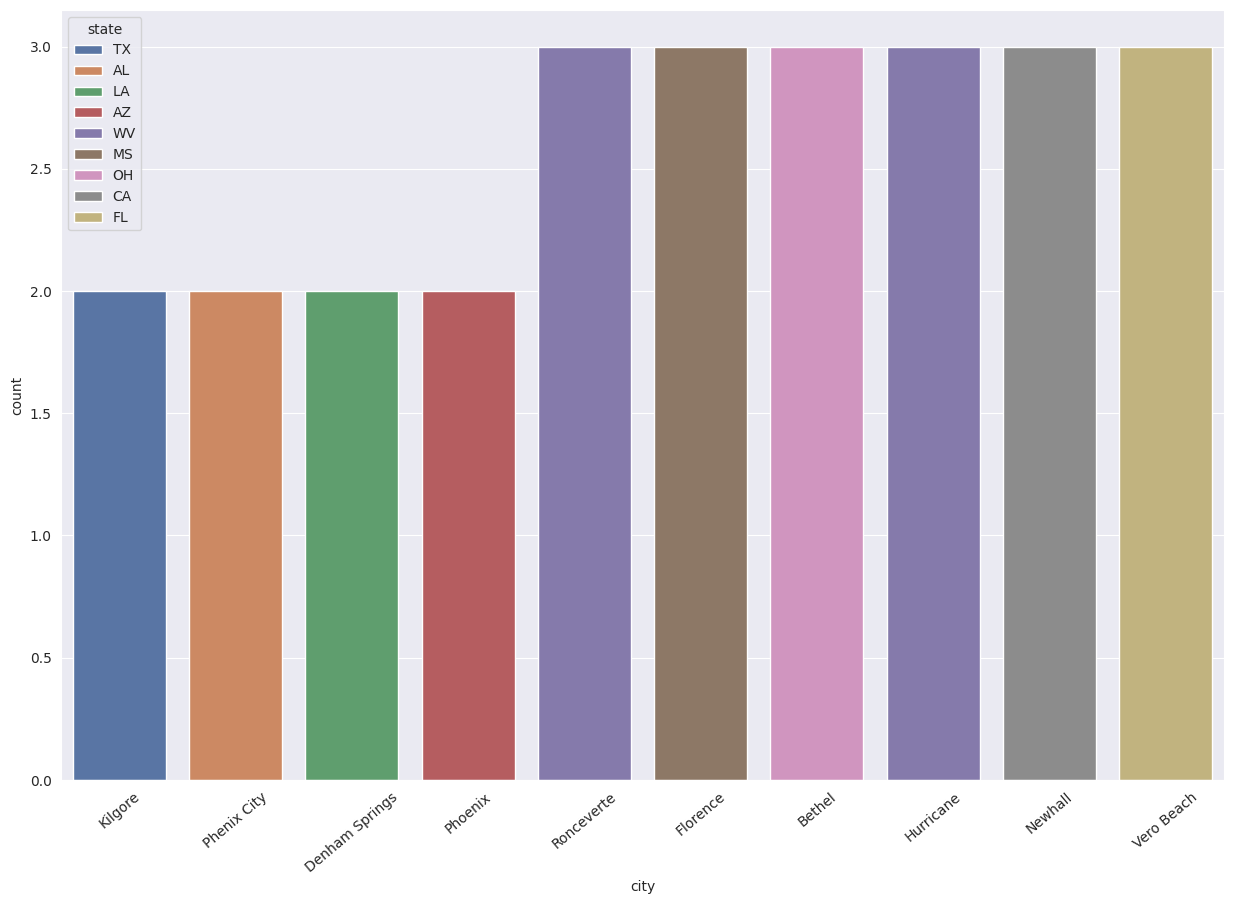

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby(['state','city'])['is_fraud'].count().reset_index(name='count').sort_values(by='count').head(10)
sns.barplot(x='city',y='count',hue='state',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

In [ ]:
len(train_data['state'].unique())

51

In [ ]:
len(train_data['city'].unique())

894

## Top 10 State-City combinations with the highest number of transactions

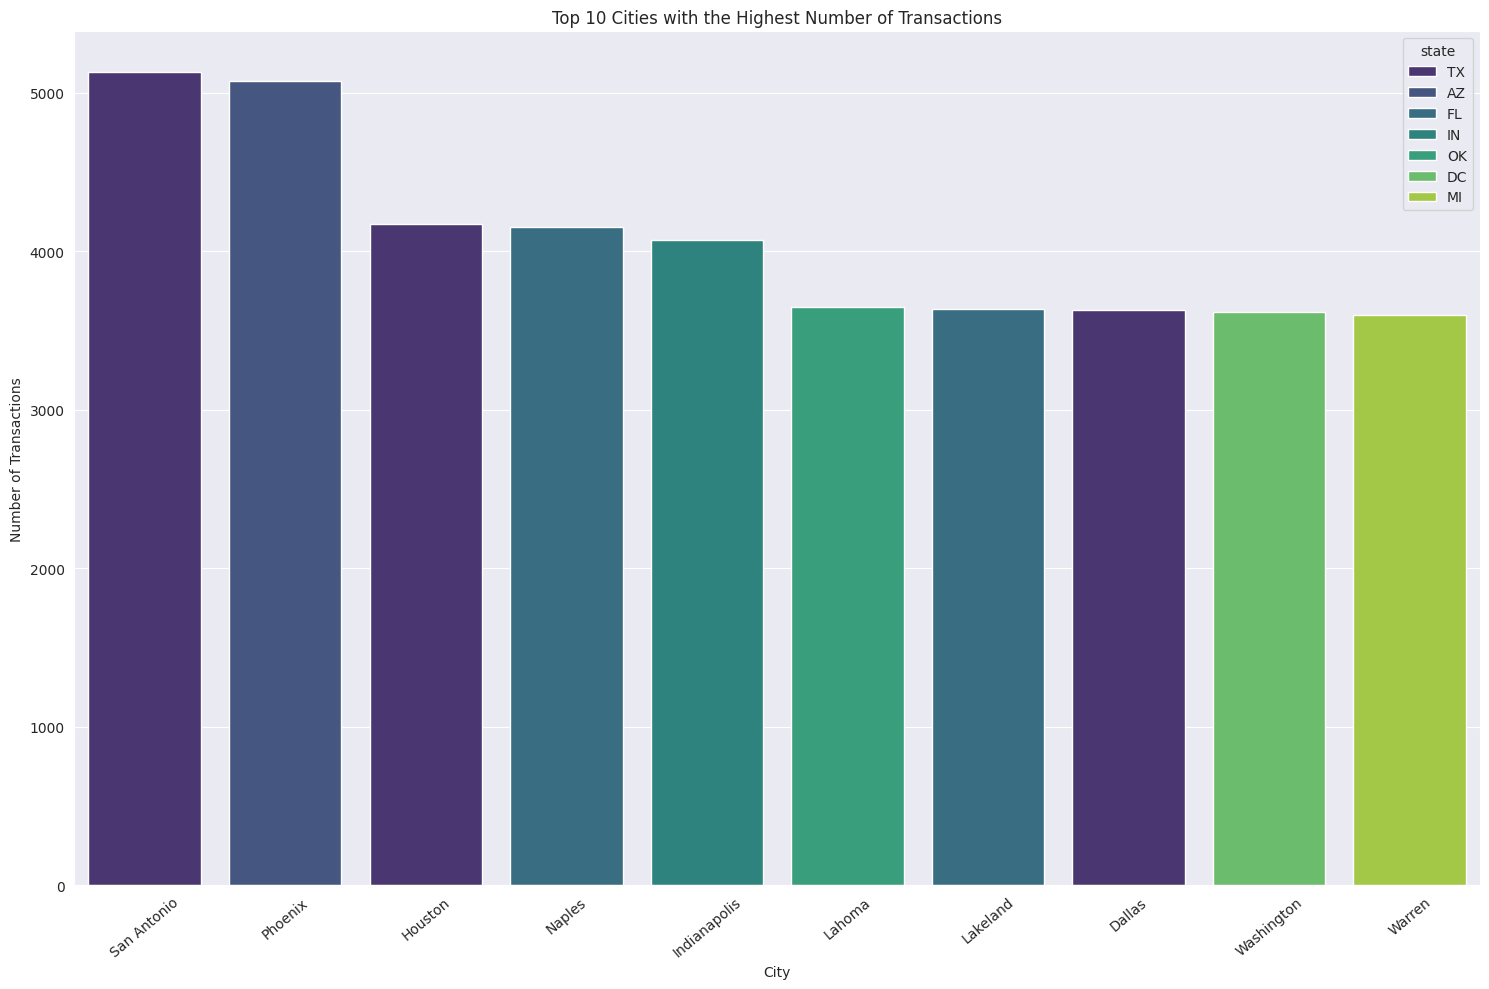

In [ ]:
# Group by 'state' and count the number of cities in each state
grouped_data = (
    train_data.groupby(['city','state'])
    .size()  # No of rows for each city
    .reset_index(name='transaction_count')
    .sort_values(by='transaction_count', ascending=False)
    .head(10)  # Take the top 10 states with the most unique cities
)

# Plot the data using seaborn
sns.barplot(x='city', y='transaction_count',hue='state',data=grouped_data, palette='viridis')
plt.xticks(rotation=40)
plt.title("Top 10 Cities with the Highest Number of Transactions")
plt.xlabel("City")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()


## Top 10 State-City combinations with least amount of transactions

In [ ]:
train_data.groupby(['state','city'])['is_fraud'].size().reset_index(name='count').sort_values(by='count').head(10)

,state,city,count
692,PA,Karns City,7
756,TN,Chattanooga,7
854,VA,Norfolk,7
217,IL,Streator,7
227,IN,Claypool,7
416,MS,Bruce,7
89,CA,Vacaville,7
344,MI,Gaines,8
406,MO,Pleasant Hill,8
445,NC,Crouse,8


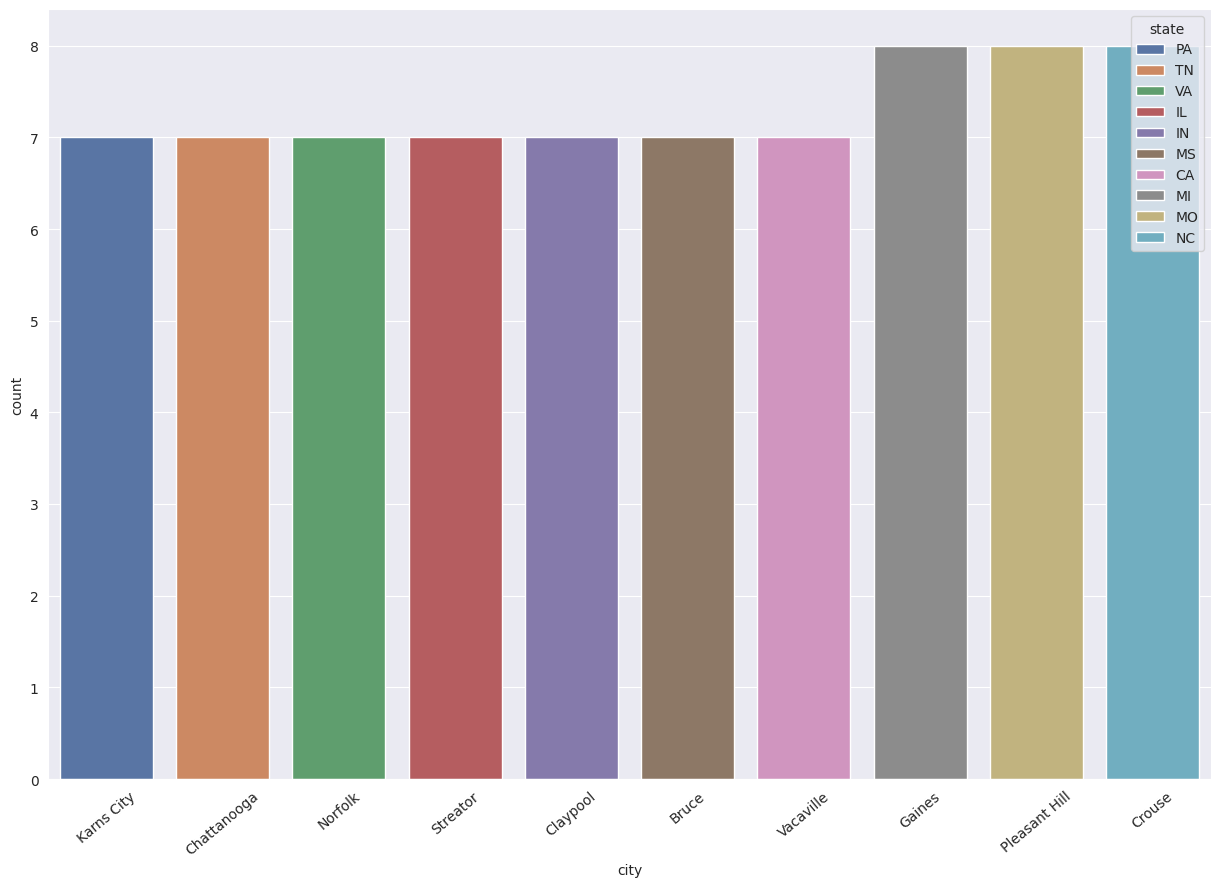

In [ ]:
grouped_data=train_data.groupby(['state','city'])['is_fraud'].size().reset_index(name='count').sort_values(by='count').head(10)
sns.barplot(x='city',y='count',hue='state',data=pd.DataFrame(grouped_data))
plt.xticks(rotation=40)
plt.show()

## Top 10 categories with most frauds

In [ ]:
train_data[train_data['is_fraud']==1].groupby('category')['is_fraud'].value_counts().sort_values(ascending=False).head(10)

,,count
category,is_fraud,
grocery_pos,1,1743
shopping_net,1,1713
misc_net,1,915
shopping_pos,1,843
gas_transport,1,618
misc_pos,1,250
kids_pets,1,239
entertainment,1,233
personal_care,1,220


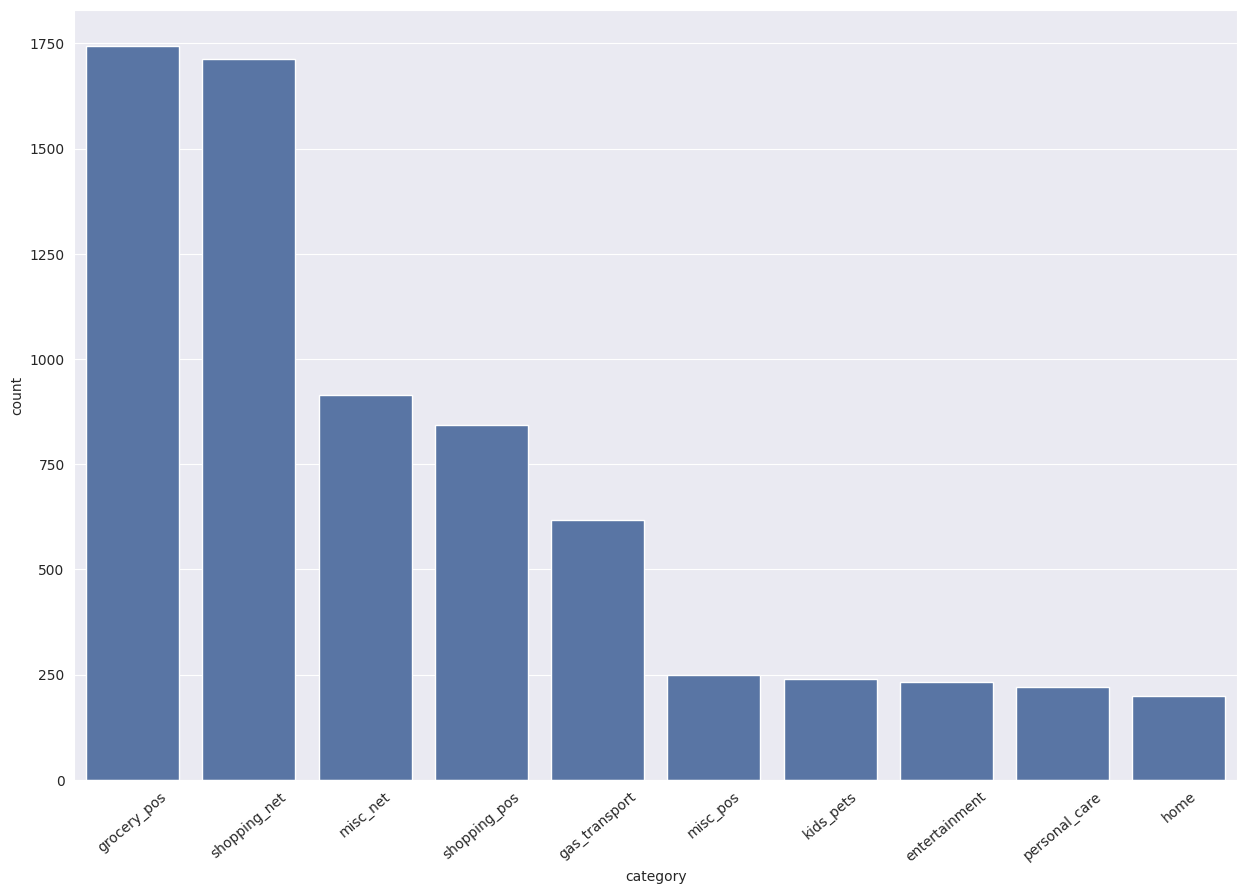

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby('category')['is_fraud'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(10)
sns.barplot(x='category',y='count',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

## Top 10 categories with least amount of frauds

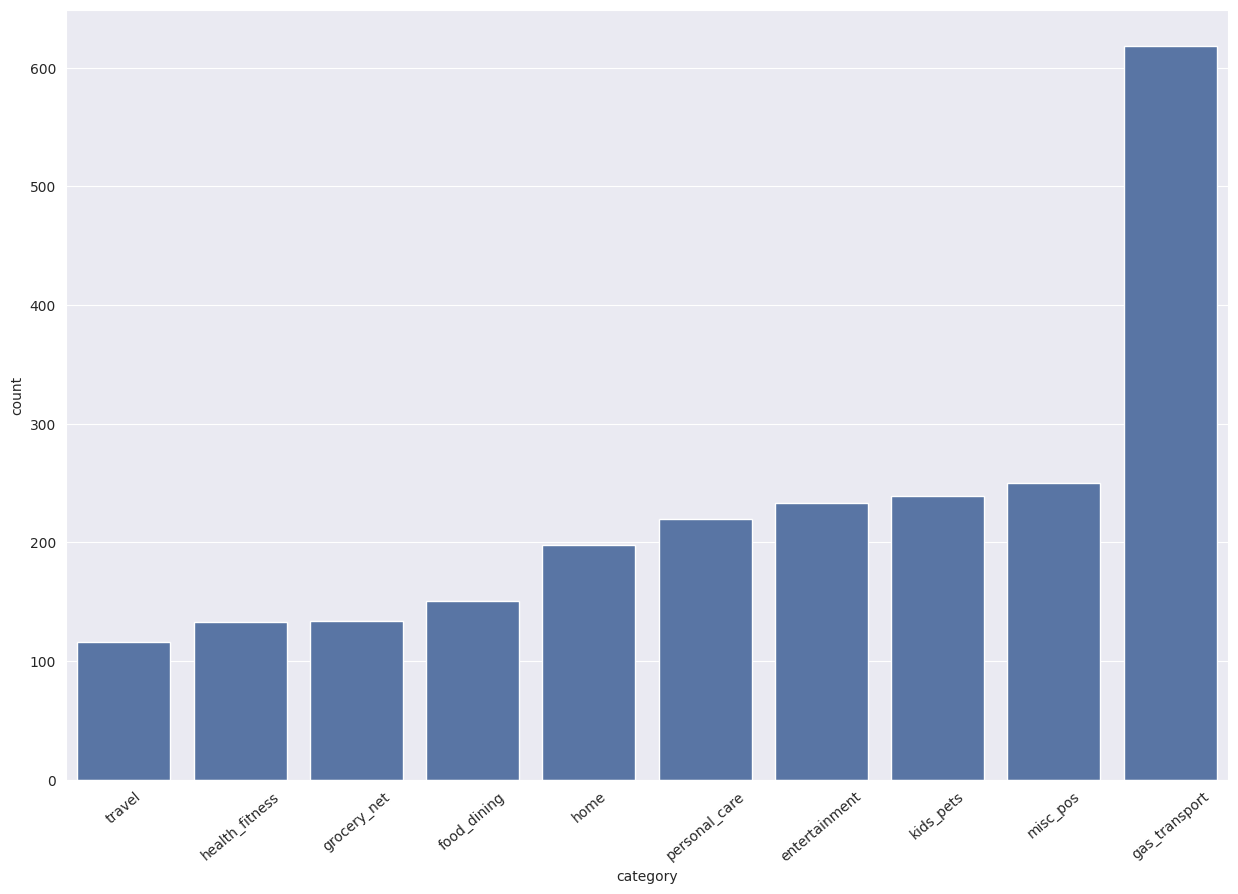

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby('category')['is_fraud'].count().reset_index(name='count').sort_values(by='count').head(10)
sns.barplot(x='category',y='count',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

## Top 10 categories with most frauds according to the city

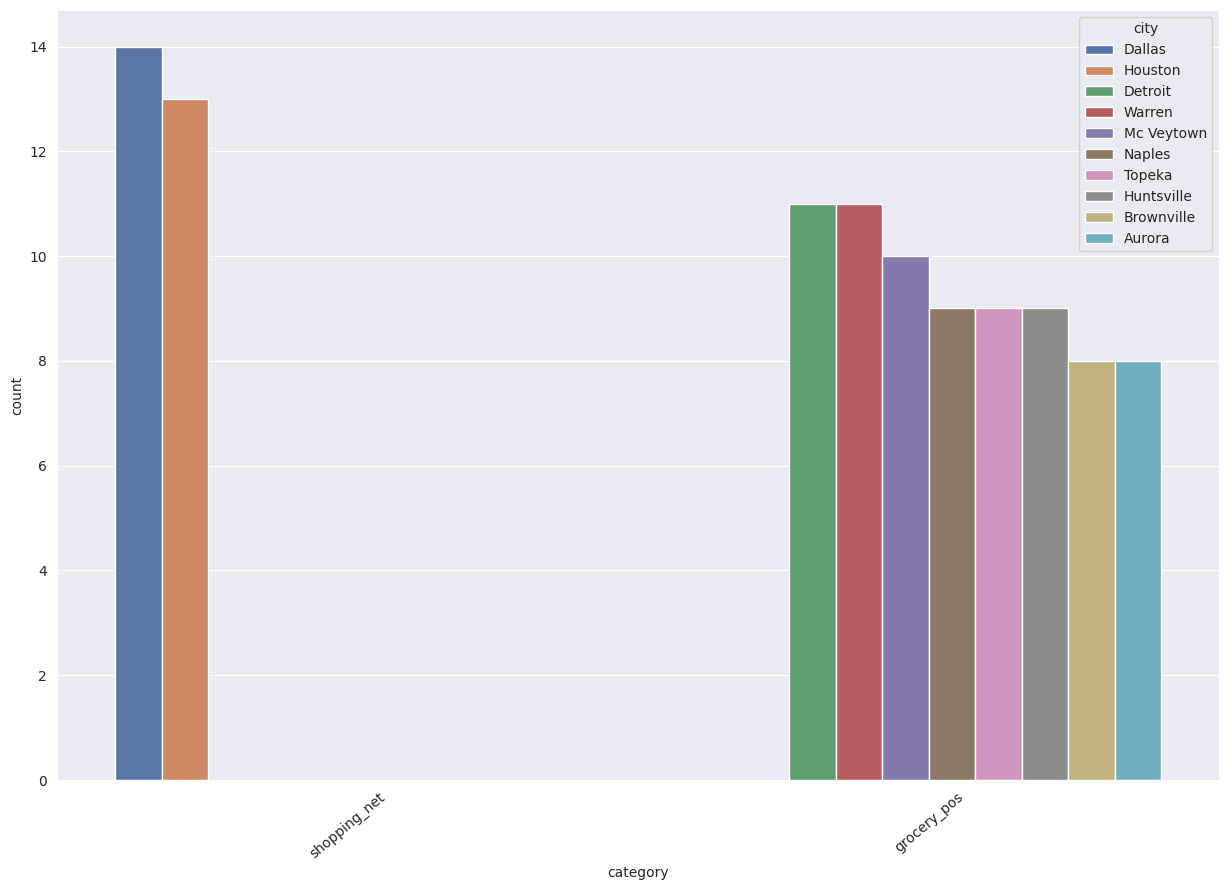

In [ ]:
grouped_data=train_data[train_data['is_fraud']==1].groupby(['category','city'])['state'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(10)
sns.barplot(x='category',y='count',hue='city',data=grouped_data)
plt.xticks(rotation=40)
plt.show()

## Top-10 cities with most population with highest no of frauds

In [ ]:
top_10_city_pop_fraud=train_data[train_data['is_fraud']==1].groupby('city')['city_pop'].value_counts().sort_values(ascending=False).head(10)
top_10_city_pop_fraud=top_10_city_pop_fraud.reset_index(name='count')
top_10_city_pop_fraud

,city,city_pop,count
0,Houston,2906700,39
1,Huntsville,190178,29
2,Naples,276002,29
3,Topeka,163415,27
4,Dallas,1263321,27
5,Tulsa,413574,27
6,Detroit,673342,26
7,San Antonio,1595797,25
8,Clearwater,172247,24
9,Beaver Falls,28425,24


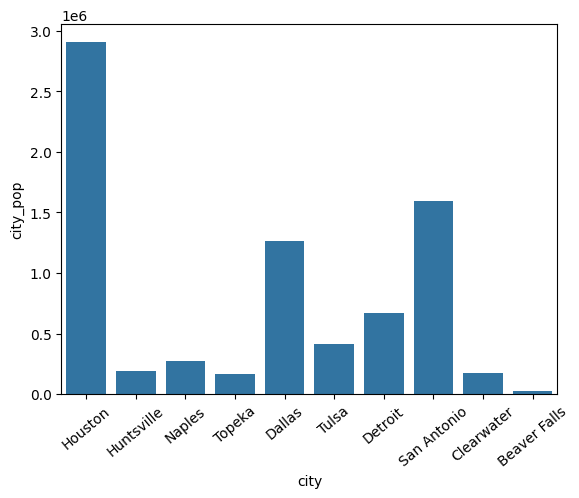

In [ ]:
sns.barplot(x='city',y='city_pop',data=top_10_city_pop_fraud)
plt.xticks(rotation=40)
plt.show()

## Top-10 cities with least amount of population with most frauds

In [ ]:
top_10_city_pop_least_fraud=train_data[train_data['is_fraud']==1].groupby('city')['city_pop'].value_counts().sort_values().head(10)
top_10_city_pop_least_fraud=top_10_city_pop_least_fraud.reset_index(name='count')
top_10_city_pop_least_fraud

,city,city_pop,count
0,Denham Springs,71335,2
1,Kilgore,24536,2
2,Phoenix,1312922,2
3,Phenix City,59744,2
4,Tupper Lake,6120,3
5,Newhall,34882,3
6,Florence,19685,3
7,Hurricane,21902,3
8,Grandview,5875,3
9,Bethel,12349,3


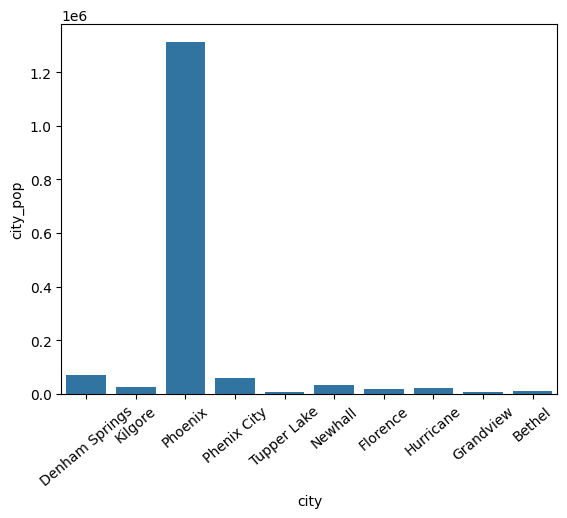

In [ ]:
sns.barplot(x='city',y='city_pop',data=top_10_city_pop_least_fraud)
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with most population and high number of frauds

In [ ]:
top_10_cities=train_data[train_data['is_fraud']==1].groupby('city').agg({'city_pop':'max','is_fraud':'count'}).sort_values(by='city_pop',ascending=False).head(10).reset_index()
top_10_cities

,city,city_pop,is_fraud
0,Houston,2906700,39
1,Brooklyn,2504700,10
2,Los Angeles,2383912,9
3,San Antonio,1595797,25
4,New York City,1577385,23
5,Philadelphia,1526206,6
6,Las Vegas,1417793,8
7,Bronx,1382480,8
8,Phoenix,1312922,2
9,Dallas,1263321,27


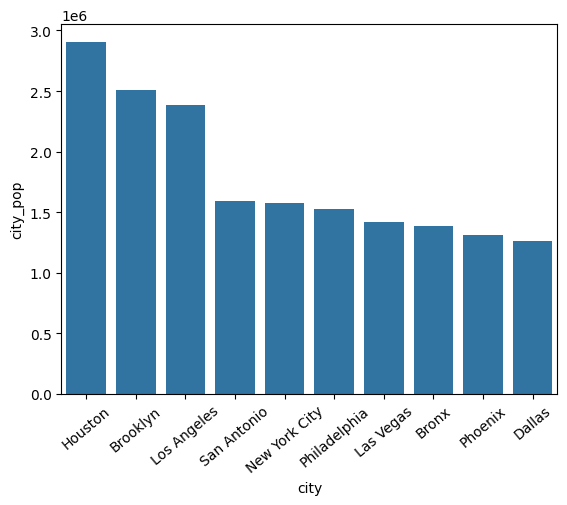

In [ ]:
sns.barplot(x='city',y='city_pop',data=top_10_cities)
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with least amount of population and more number of frauds

In [ ]:
top_10_cities=train_data[train_data['is_fraud']==1].groupby('city').agg({'city_pop':'min','is_fraud':'count'}).sort_values(by=['city_pop','is_fraud'],ascending=[True,False]).head(10).reset_index()
top_10_cities

,city,city_pop,is_fraud
0,Notrees,23,6
1,Gregory,37,9
2,Thompson,46,12
3,West Bethel,47,6
4,Lonetree,49,14
5,Randolph,51,25
6,Ferney,52,12
7,Summerfield,53,18
8,Oran,53,9
9,Kent,60,13


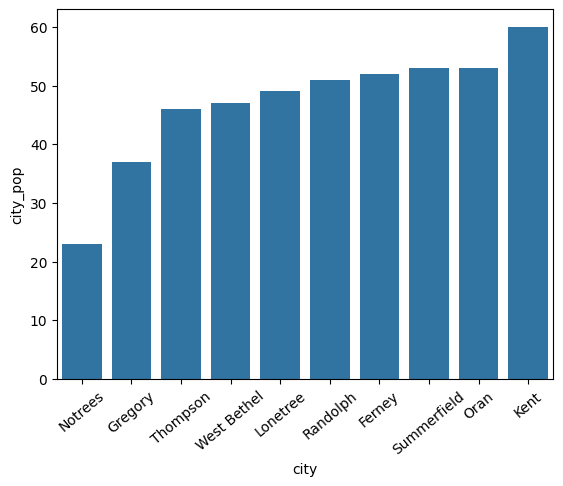

In [ ]:
sns.barplot(x='city',y='city_pop',data=top_10_cities)
plt.xticks(rotation=40)
plt.show()

## Top 10 cities with more population and more number of frauds

In [ ]:
top_10_cities=train_data[train_data['is_fraud']==1].groupby('city').agg({'city_pop':'max','is_fraud':'count'}).sort_values(by=['is_fraud','city_pop'],ascending=[False,False]).head(10).reset_index()
top_10_cities

,city,city_pop,is_fraud
0,Houston,2906700,39
1,Warren,134056,33
2,Naples,276002,29
3,Huntsville,190178,29
4,Dallas,1263321,27
5,Tulsa,413574,27
6,Topeka,163415,27
7,Detroit,673342,26
8,San Antonio,1595797,25
9,Randolph,1201,25


## Top 10 cities with more population and least number of frauds

In [ ]:
top_10_cities=train_data[train_data['is_fraud']==1].groupby('city').agg({'city_pop':'max','is_fraud':'count'}).sort_values(by=['is_fraud','city_pop'],ascending=[True,False]).head(10).reset_index()
top_10_cities

,city,city_pop,is_fraud
0,Phoenix,1312922,2
1,Denham Springs,71335,2
2,Phenix City,59744,2
3,Kilgore,24536,2
4,Vero Beach,105638,3
5,Newhall,34882,3
6,Hurricane,21902,3
7,Florence,19685,3
8,Bethel,12349,3
9,Tupper Lake,6120,3


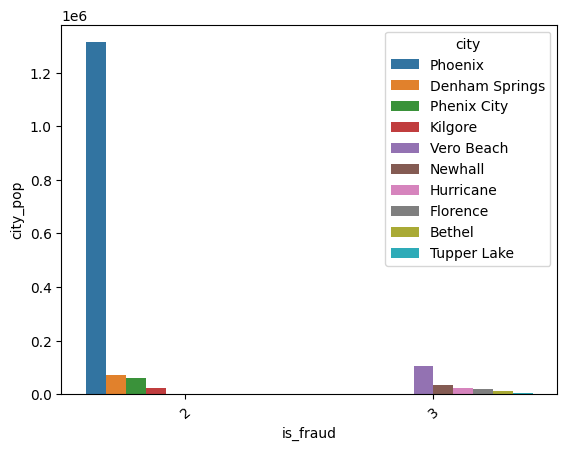

In [ ]:
sns.barplot(x='is_fraud',y='city_pop',hue='city',data=top_10_cities)
plt.xticks(rotation=40)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


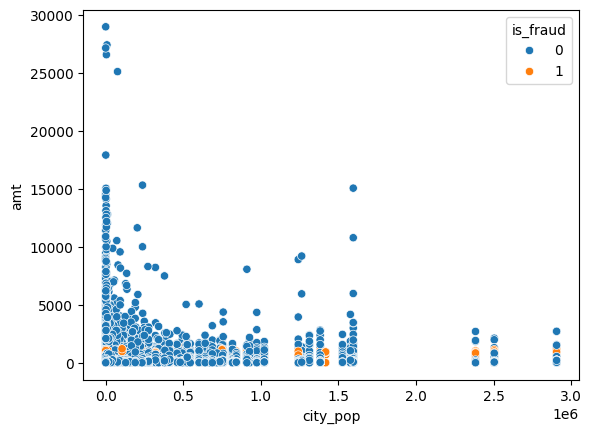

In [ ]:
sns.scatterplot(x='city_pop',y='amt',hue='is_fraud',data=train_data)
plt.show()

In [ ]:
train_data.dtypes

,0
merchant,object
category,object
amt,float64
gender,object
city,object
state,object
lat,float64
long,float64
city_pop,int64
merch_lat,float64


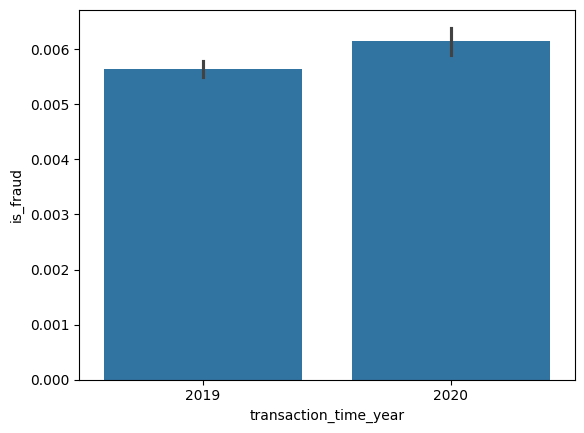

In [ ]:
sns.barplot(x='transaction_time_year',y='is_fraud',data=train_data)
plt.show()

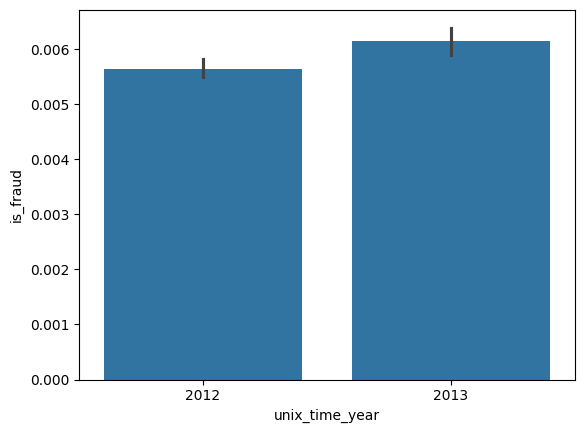

In [ ]:
sns.barplot(x='unix_time_year',y='is_fraud',data=train_data)
plt.show()

In [ ]:
len(train_data['category'].unique())

14

In [ ]:
train_data['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

## Implementing label encoding for gender column

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_data['gender_encoded']=le.fit_transform(train_data['gender'])
train_data['gender_encoded'].head()

,gender_encoded
0,0
1,0
2,1
3,1
4,1


In [ ]:
#test_data['gender_encoded']=le.fit_transform(test_data['gender'])
#test_data['gender_encoded'].head()

,gender_encoded
0,1
1,0
2,0
3,1
4,1


In [ ]:
len(train_data['state'].unique()),len(train_data['city'].unique())

(51, 894)

## Implementing target encoding for category and state column

In [ ]:
train_data

,merchant,category,amt,gender,city,state,lat,long,city_pop,merch_lat,merch_long,is_fraud,transaction_time_year,transaction_time_month,transaction_time_day,transaction_time_hour,transaction_time_min,transaction_time_sec,gender_encoded
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,36.011293,-82.048315,0,2019,1,1,0,0,18,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,49.159047,-118.186462,0,2019,1,1,0,0,44,0
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,43.150704,-112.154481,0,2019,1,1,0,0,51,1
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,47.034331,-112.561071,0,2019,1,1,0,1,16,1
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,38.674999,-78.632459,0,2019,1,1,0,3,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,Hatch,UT,37.7175,-112.4777,258,36.841266,-111.690765,0,2020,6,21,12,12,8,1
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,Tuscarora,MD,39.2667,-77.5101,100,38.906881,-78.246528,0,2020,6,21,12,12,19,1
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,High Rolls Mountain Park,NM,32.9396,-105.8189,899,33.619513,-105.130529,0,2020,6,21,12,12,32,1
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,Manderson,SD,43.3526,-102.5411,1126,42.788940,-103.241160,0,2020,6,21,12,13,36,1


In [ ]:
import pandas as pd
import pickle
import boto3
from io import BytesIO

s3_client = boto3.client('s3')

def target_encoding(col, df, bucket_name, file_key):
    # Calculate the mean of 'is_fraud' for each category
    encoding_dict = df.groupby(col)['is_fraud'].mean()

    # Save encoding to S3
    buffer = BytesIO()
    pickle.dump(encoding_dict, buffer)
    buffer.seek(0)
    s3_client.put_object(Bucket=bucket_name, Key=file_key, Body=buffer.getvalue())
    print(f"Encoding dictionary saved to S3")

    # Apply encoding to training data
    df[f'{col}_encoded'] = df[col].map(encoding_dict).fillna(encoding_dict.mean())
    print(f"Target encoding applied to '{col}' in training data.")

    return df

In [ ]:
# Serialize using pickle
buffer = BytesIO()
pickle.dump(target_encoding, buffer)
buffer.seek(0)

# Upload to S3
s3_client = boto3.client('s3')
file_key = 'target_encoding.pkl'

s3_client.put_object(Bucket=bucket_name, Key=file_key, Body=buffer.getvalue())
print("Function saved as a pickle file in S3.")

Function saved as a pickle file in S3.


In [ ]:
train_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'lat', 'long',
       'city_pop', 'merch_lat', 'merch_long', 'is_fraud',
       'transaction_time_year', 'transaction_time_month',
       'transaction_time_day', 'transaction_time_hour', 'transaction_time_min',
       'transaction_time_sec', 'gender_encoded'],
      dtype='object')

In [ ]:
train_data = target_encoding('category', train_data, bucket_name, 'category_encoding.pkl')
train_data = target_encoding('state', train_data, bucket_name, 'state_encoding.pkl')

Encoding dictionary saved to S3
Target encoding applied to 'category' in training data.
Encoding dictionary saved to S3
Target encoding applied to 'state' in training data.


In [ ]:
s3_key = 'kfold_encoding.pkl'

def kfold_target_encoding(df, col, target_col, n_splits=5, bucket_name=None, s3_key=None):
    # Initialize encoded column as float
    df[f'{col}_encoded'] = 0.0
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform KFold target encoding
    for train_idx, val_idx in kf.split(df):
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
        fold_means = train_fold.groupby(col)[target_col].mean()
        df.loc[val_idx, f'{col}_encoded'] = df.loc[val_idx, col].map(fold_means)

    # Compute global mean for unseen categories
    global_mean = df[target_col].mean()

    # Create the final mapping with overall means
    overall_means = df.groupby(col)[f'{col}_encoded'].mean().to_dict()

    # Apply mapping to training data with fallback to global mean
    df[f'{col}_encoded'] = df[col].map(overall_means).fillna(global_mean)

    # Save the encoding mapping to S3 if bucket name and key are provided
    if bucket_name and s3_key:
        try:
            encoding_data = pickle.dumps(overall_means)
            s3_client.put_object(Bucket=bucket_name, Key=s3_key, Body=encoding_data)
            print(f"Encoding mapping saved to S3")
        except Exception as e:
            print(f"Failed to upload encoding mapping to S3: {e}")

    return df, overall_means

# Example usage
train_data, encoding_mapping = kfold_target_encoding(
    train_data,
    col='city', target_col='is_fraud',
    n_splits=5, bucket_name=bucket_name, s3_key=s3_key
)

print(train_data[['city_encoded']].head())

Encoding mapping saved to S3
   city_encoded
0      0.000000
1      0.000000
2      0.000000
3      0.030171
4      0.000000


In [ ]:
s3_client = boto3.client('s3')

buffer = pickle.dumps(encoding_mapping)
s3_client.put_object(Bucket=bucket_name, Key=s3_key, Body=buffer)
print(f"Encoding mapping saved to S3")

Encoding mapping saved to S3


In [ ]:
train_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'lat', 'long',
       'city_pop', 'merch_lat', 'merch_long', 'is_fraud',
       'transaction_time_year', 'transaction_time_month',
       'transaction_time_day', 'transaction_time_hour', 'transaction_time_min',
       'transaction_time_sec', 'gender_encoded', 'category_encoded',
       'state_encoded', 'city_encoded'],
      dtype='object')

In [ ]:
print(train_data.head())

                             merchant       category     amt gender  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97      F   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23      F   
2                fraud_Lind-Buckridge  entertainment  220.11      M   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00      M   
4                 fraud_Keeling-Crist       misc_pos   41.96      M   

             city state      lat      long  city_pop  merch_lat  ...  \
0  Moravian Falls    NC  36.0788  -81.1781      3495  36.011293  ...   
1          Orient    WA  48.8878 -118.2105       149  49.159047  ...   
2      Malad City    ID  42.1808 -112.2620      4154  43.150704  ...   
3         Boulder    MT  46.2306 -112.1138      1939  47.034331  ...   
4        Doe Hill    VA  38.4207  -79.4629        99  38.674999  ...   

   transaction_time_year  transaction_time_month  transaction_time_day  \
0                   2019                       1                  

## Removing unwanted columns

In [ ]:
train_data.drop(['category','merchant','gender','city','state'],axis=1,inplace=True)
#test_data.drop(['category','merchant','gender','city','state'],axis=1,inplace=True)

In [ ]:
train_data.dtypes

,0
amt,float64
lat,float64
long,float64
city_pop,int64
merch_lat,float64
merch_long,float64
is_fraud,int64
transaction_time_year,int32
transaction_time_month,int32
transaction_time_day,int32


## Applying cyclic encoding for datetime columns

In [ ]:
import boto3
import pickle
import numpy as np

# S3 bucket details
s3_client = boto3.client('s3')
bucket_name = "credit-card-fraud-detection-system-bucket"
s3_key = "cyclic_encoding.pkl"  # File name in S3

# Dictionary of max values for cyclic encoding
cols_max_values = {
    'transaction_time_day': 31,
    'transaction_time_hour': 24,
    'transaction_time_min': 60,
    'transaction_time_sec': 60,
    'transaction_time_month':12,
}

# Function to apply cyclic encoding and save encoding parameters to S3
def cyclic_encode(df, cols_max_values, bucket_name, s3_key):
    for col, max_value in cols_max_values.items():
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_value)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_value)



    encoding_data = pickle.dumps(cols_max_values)

    s3_client.put_object(Bucket=bucket_name, Key=s3_key, Body=encoding_data)

    print(f"Cyclic encoding parameters saved to S3")


# Apply encoding and save to S3
cyclic_encode(train_data, cols_max_values, bucket_name, s3_key)


train_data.drop(['transaction_time_month','transaction_time_day','transaction_time_hour','transaction_time_min','transaction_time_sec'],axis=1,inplace=True)
#test_data.drop(['transaction_time_month','transaction_time_day','transaction_time_hour','transaction_time_min','transaction_time_sec'],axis=1,inplace=True)

Cyclic encoding parameters saved to S3


In [ ]:
train_data.dtypes

,0
amt,float64
lat,float64
long,float64
city_pop,int64
merch_lat,float64
merch_long,float64
is_fraud,int64
transaction_time_year,int32
gender_encoded,int64
category_encoded,float64


In [ ]:
print(train_data.head())

      amt      lat      long  city_pop  merch_lat  merch_long  is_fraud  \
0    4.97  36.0788  -81.1781      3495  36.011293  -82.048315         0   
1  107.23  48.8878 -118.2105       149  49.159047 -118.186462         0   
2  220.11  42.1808 -112.2620      4154  43.150704 -112.154481         0   
3   45.00  46.2306 -112.1138      1939  47.034331 -112.561071         0   
4   41.96  38.4207  -79.4629        99  38.674999  -78.632459         0   

   transaction_time_year  gender_encoded  category_encoded  ...  \
0                   2019               0          0.014458  ...   
1                   2019               0          0.014098  ...   
2                   2019               1          0.002478  ...   
3                   2019               1          0.004694  ...   
4                   2019               1          0.003139  ...   

   transaction_time_day_sin  transaction_time_day_cos  \
0                  0.201299                   0.97953   
1                  0.201299     

## Detecting outliers in amt column

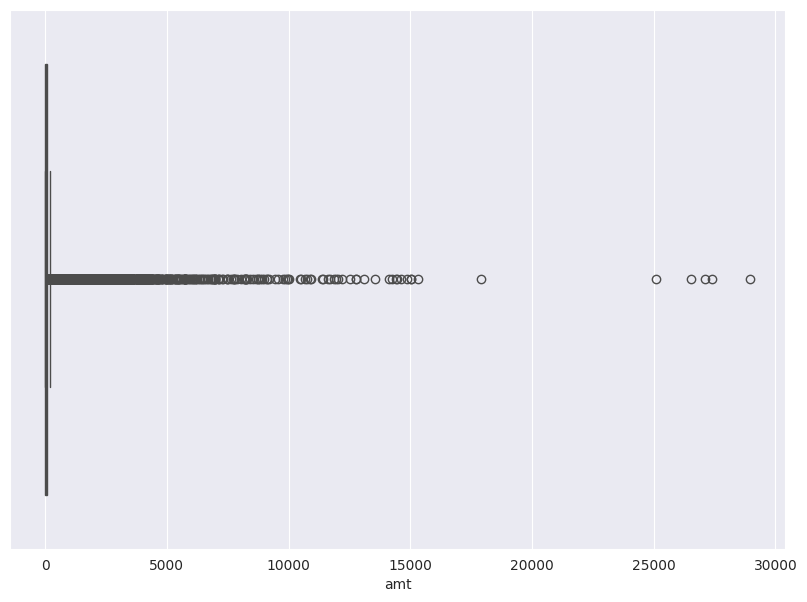

In [ ]:
sns.set({'figure.figsize':(10,7)})
sns.boxplot(x='amt',data=train_data)
plt.show()

## Finding outliers in class_0

In [ ]:
train_data.shape[1]

22

In [ ]:
class_0=train_data[train_data['is_fraud']==0]
class_0_columns=class_0.drop(['is_fraud'],axis=1).columns
class_0_columns

Index(['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
       'transaction_time_year', 'gender_encoded', 'category_encoded',
       'state_encoded', 'city_encoded', 'transaction_time_day_sin',
       'transaction_time_day_cos', 'transaction_time_hour_sin',
       'transaction_time_hour_cos', 'transaction_time_min_sin',
       'transaction_time_min_cos', 'transaction_time_sec_sin',
       'transaction_time_sec_cos', 'transaction_time_month_sin',
       'transaction_time_month_cos'],
      dtype='object')

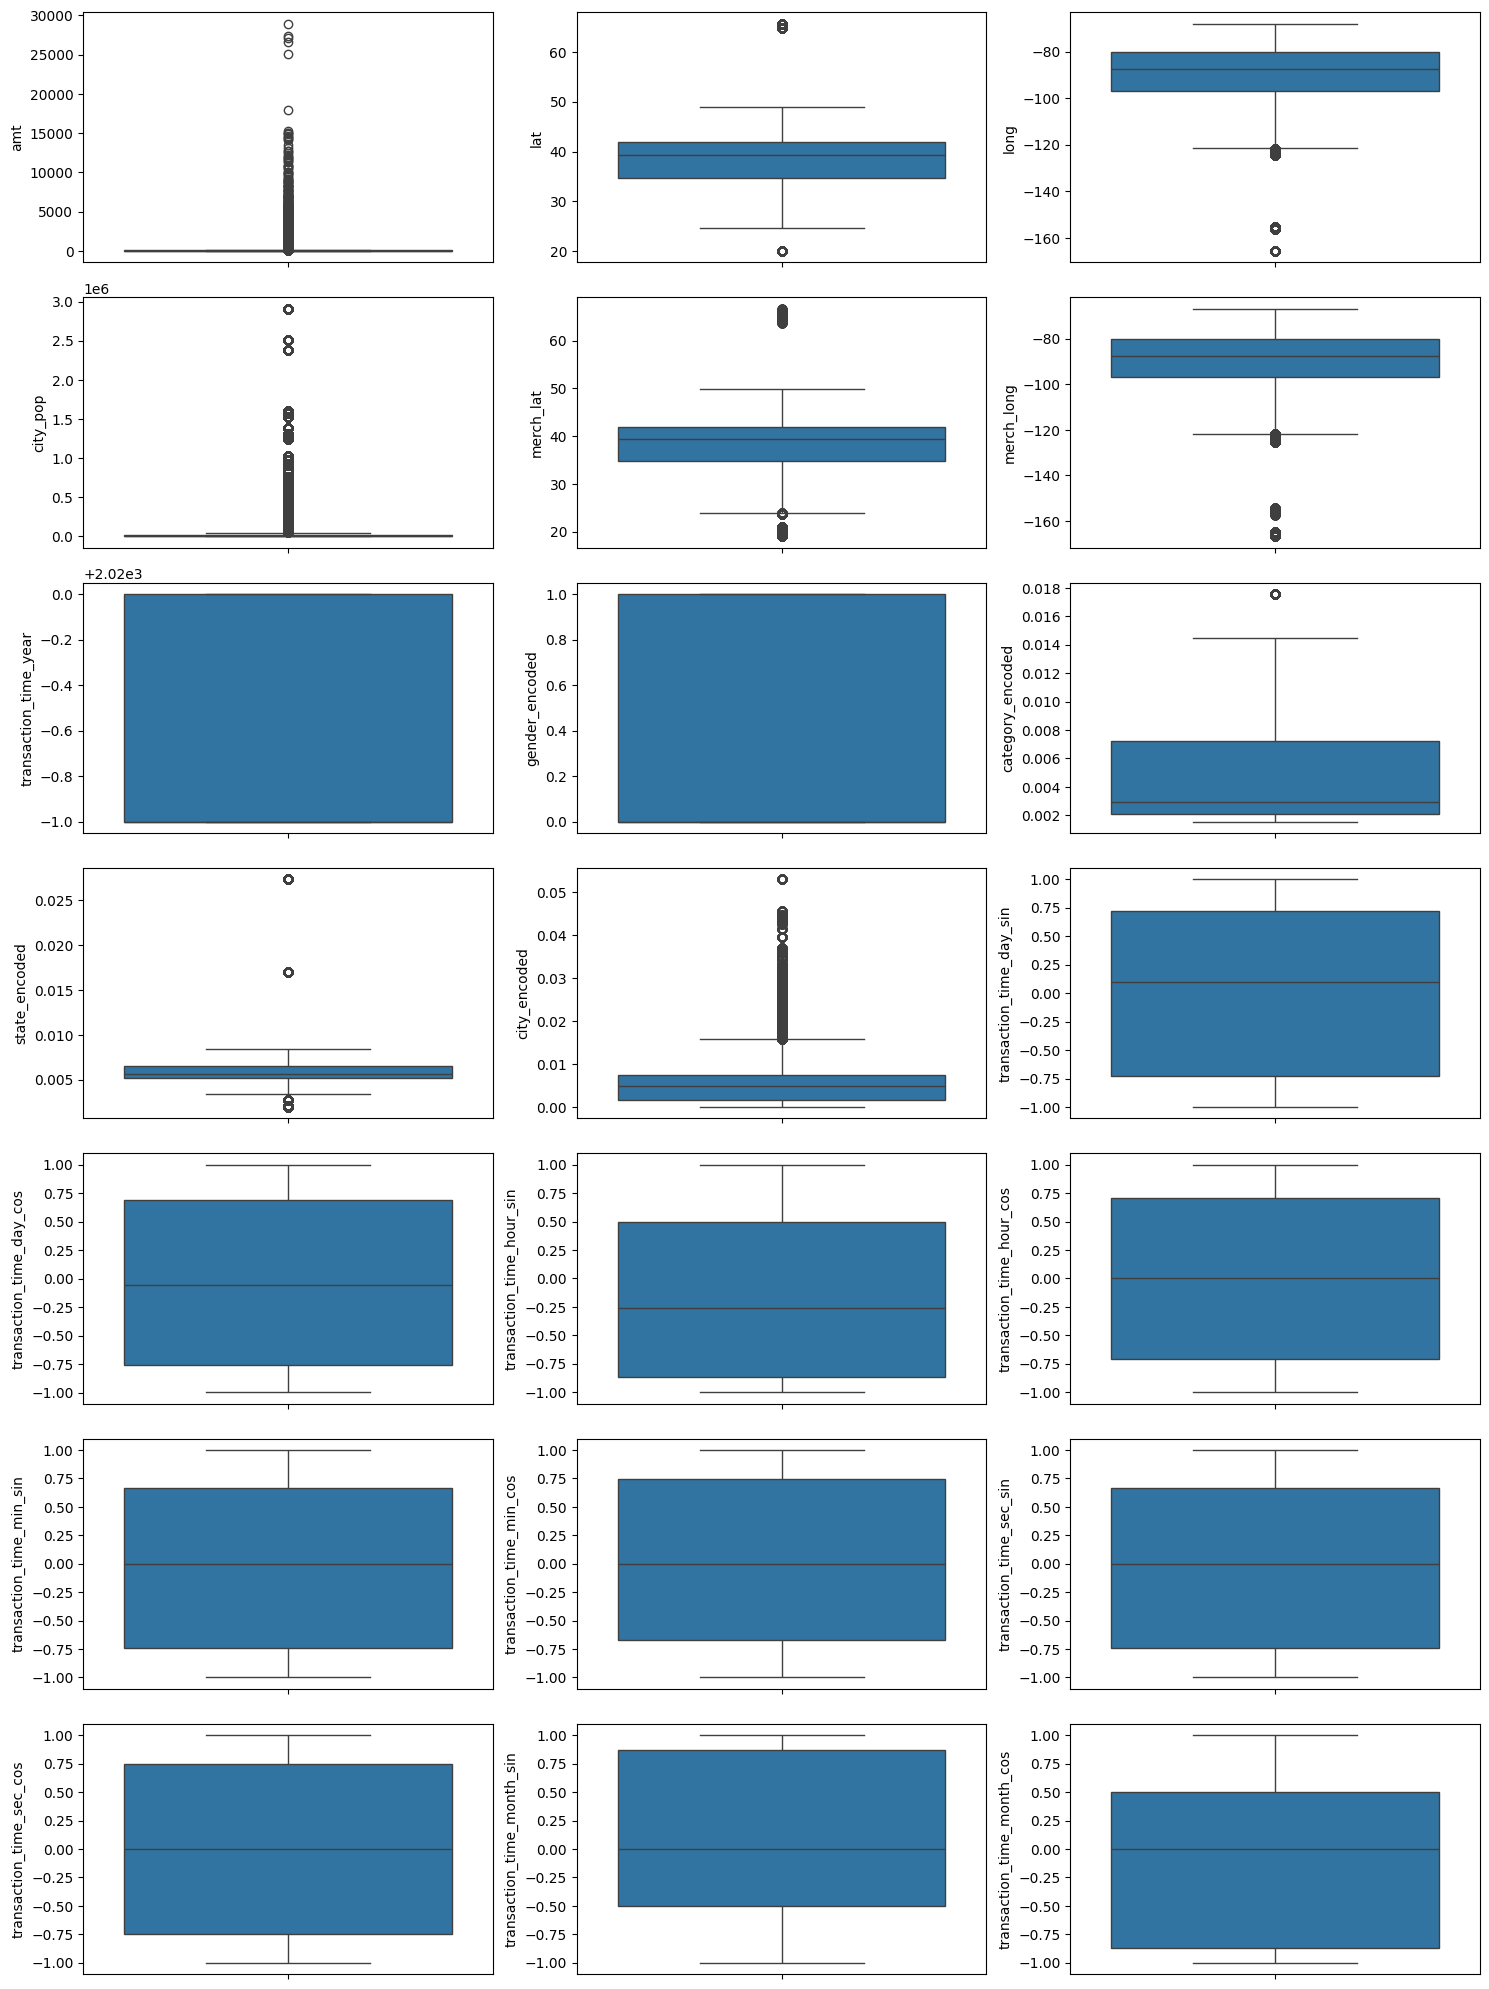

In [ ]:
fig,axes=plt.subplots(7,3,figsize=(15,20))
axes=axes.flatten()
for col,ax in zip(class_0_columns,axes):
  sns.boxplot(y=col,data=class_0,ax=ax)
  ax.set_ylabel(col)
plt.tight_layout()
plt.show()

## Detecting outliers in class 1

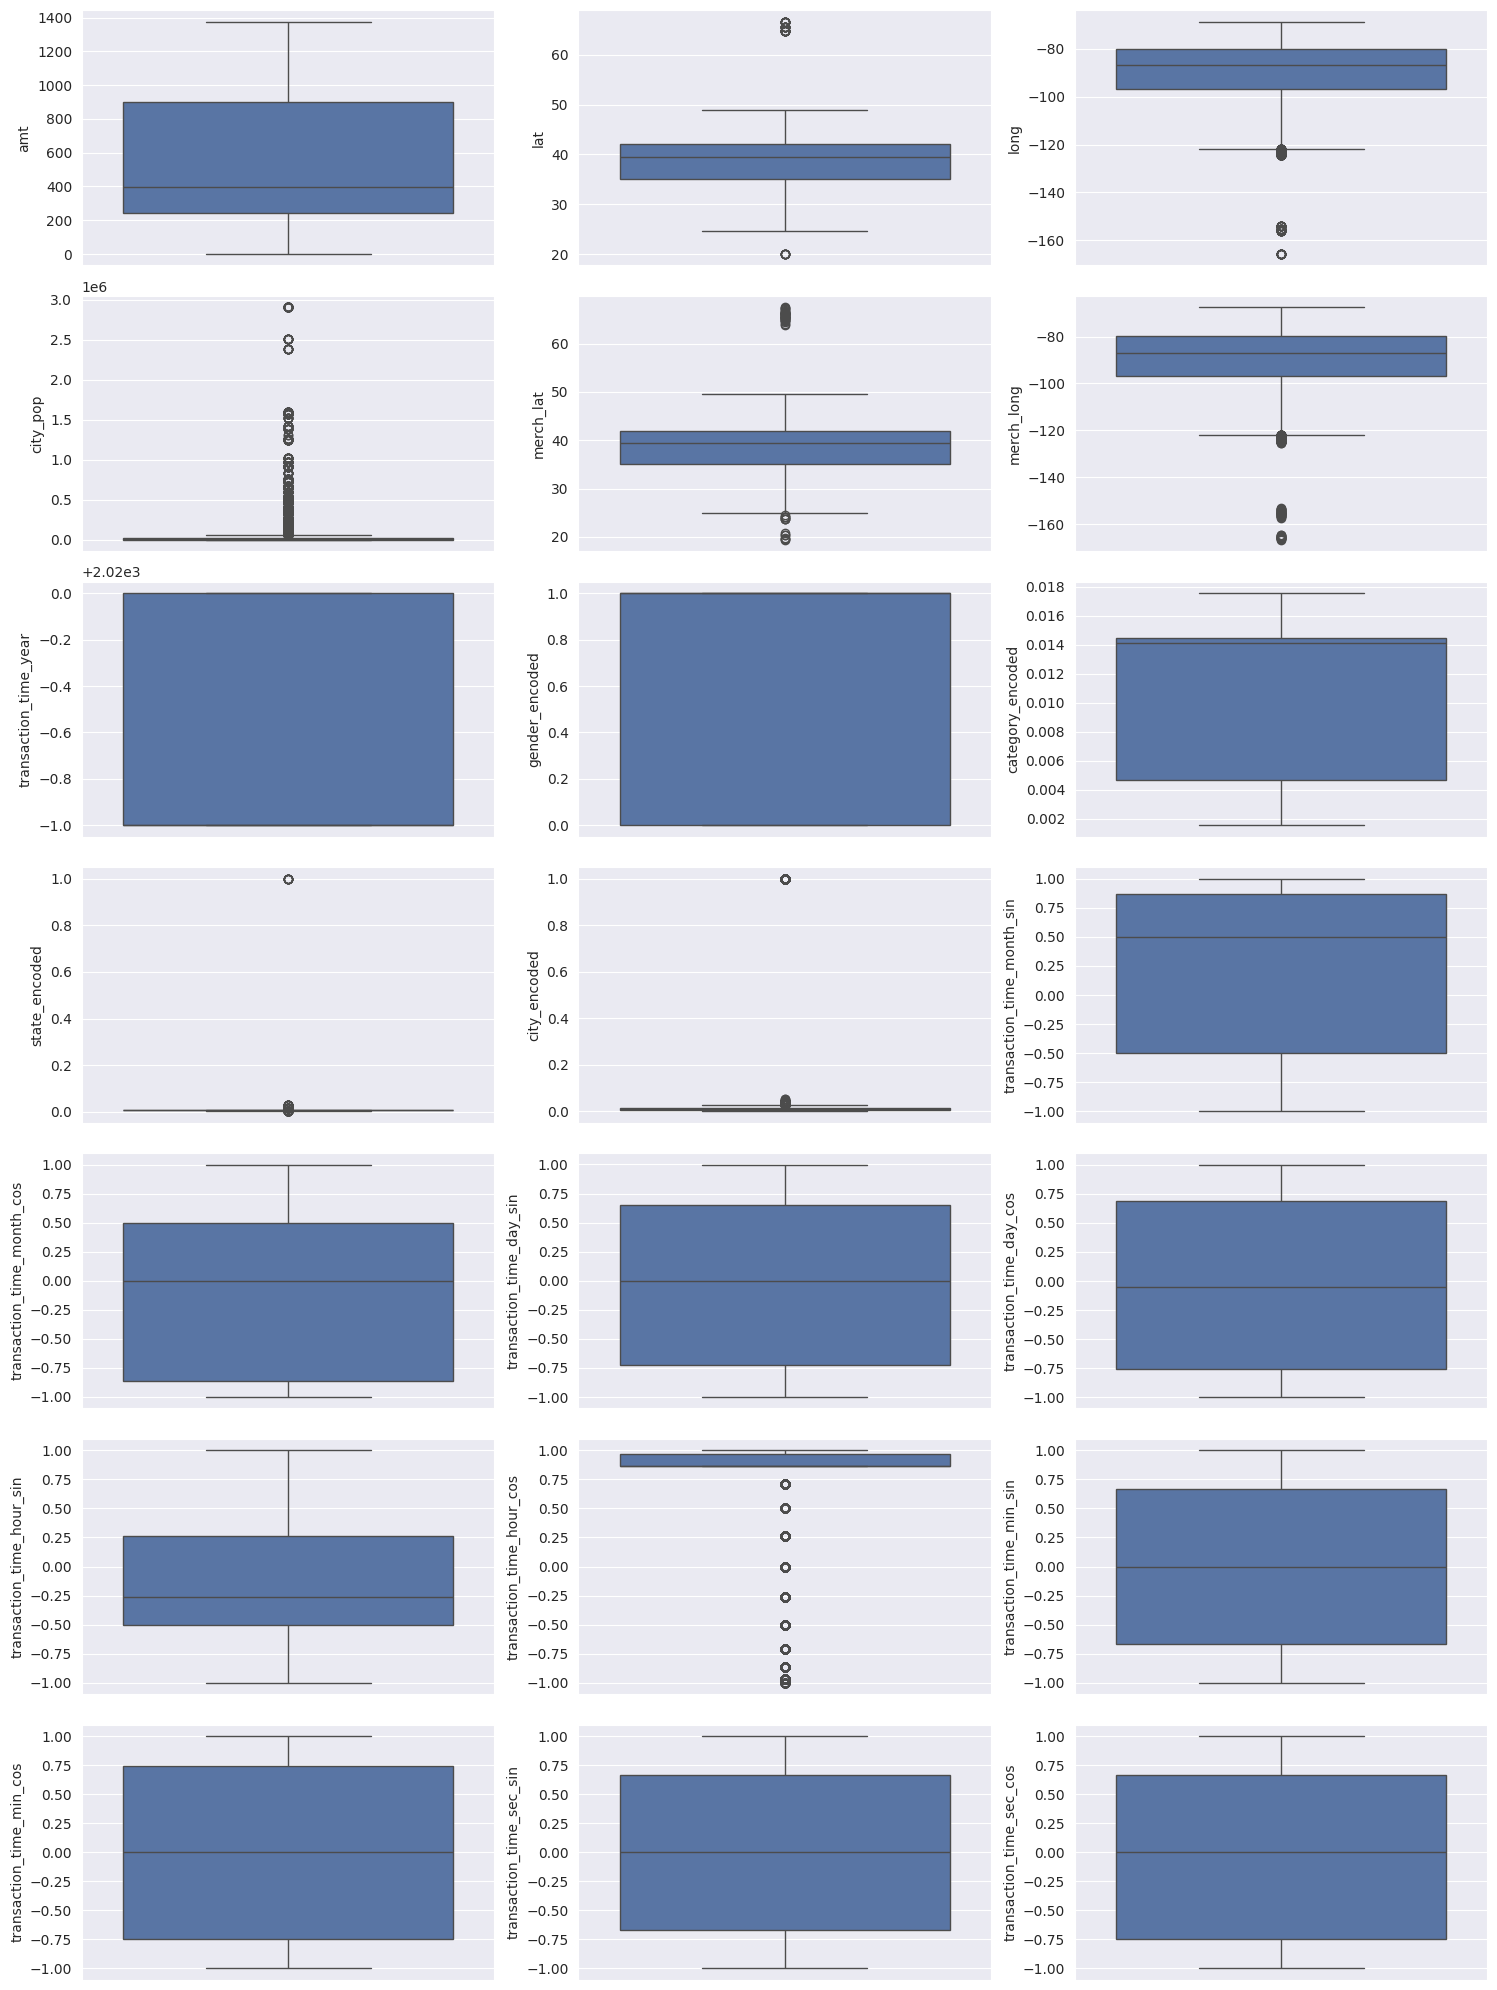

In [ ]:
class_1=train_data[train_data['is_fraud']==1]
class_1_columns=class_1.drop(['is_fraud'],axis=1).columns
fig,axes=plt.subplots(7,3,figsize=(15,20))
axes=axes.flatten()
for col,ax in zip(class_1_columns,axes):
  sns.boxplot(y=col,data=class_1,ax=ax)
  ax.set_ylabel(col)
plt.tight_layout()
plt.show()

## Check if the columns lat,long_merch_lat,merch_long columns are normally distributed

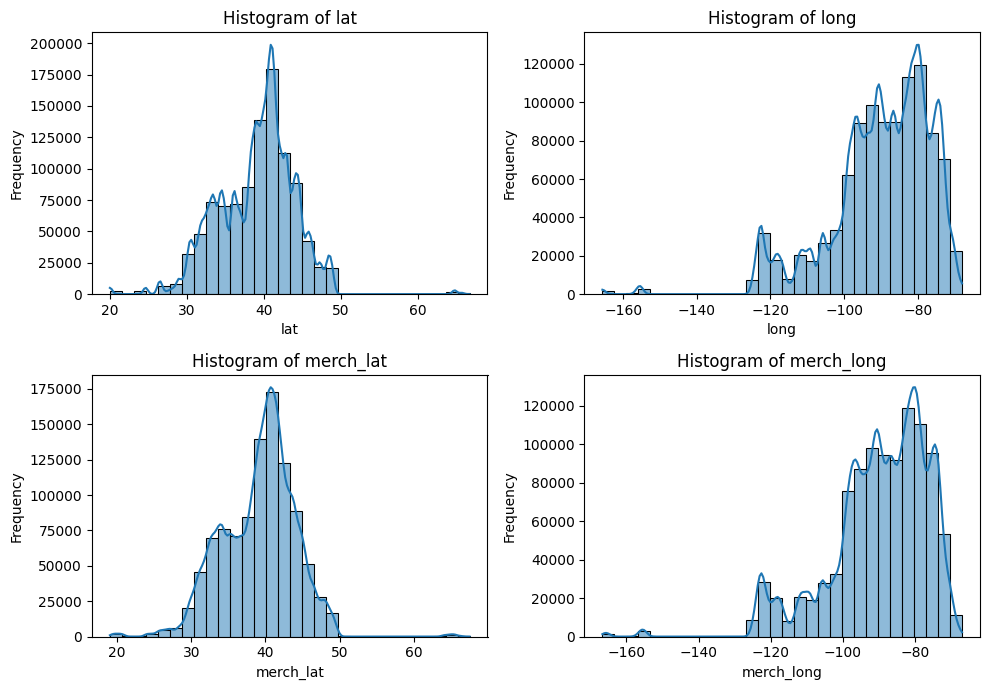

In [ ]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(2,2,figsize=(10,7))
axes=axes.flatten()
for col,ax in zip(['lat','long','merch_lat','merch_long'],axes):
  # Plot a histogram to visually inspect the distribution
  sns.histplot(data=train_data,x=col,kde=True, bins=30, edgecolor='black',ax=ax)
  ax.set_title(f'Histogram of {col}')
  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
train_data.shape

(1005736, 22)

In [ ]:
from scipy.stats import kurtosis,skew
k=train_data[['lat','long','merch_lat','merch_long']].apply(kurtosis).sort_values(ascending=False)
k

,0
long,-0.006715
merch_long,-0.015005
merch_lat,-0.423159
lat,-0.429977


In [ ]:
s=train_data[['lat','long','merch_lat','merch_long']].apply(skew).sort_values(ascending=False)
s

,0
merch_lat,-0.279010
lat,-0.288346
merch_long,-0.633806
long,-0.638345


## Removing outliers only from the majority class

In [ ]:
def remove_outliers(df, cols):
    # Separate the classes
    class_0 = df[df['is_fraud'] == 0]
    class_1 = df[df['is_fraud'] == 1]

    # Apply IQR outlier removal for specified columns
    for col in cols:
        q1 = class_0[col].quantile(0.25)
        q3 = class_0[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        class_0 = class_0[(class_0[col] >= lower_bound) & (class_0[col] <= upper_bound)]
        print(f"Outliers removed from {col}")

    # Combine filtered class_0 with untouched class_1
    return pd.concat([class_0, class_1], ignore_index=True)



In [ ]:
columns_to_check = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
train_data = remove_outliers(train_data, columns_to_check)

Outliers removed from amt
Outliers removed from city_pop
Outliers removed from lat
Outliers removed from long
Outliers removed from merch_lat
Outliers removed from merch_long


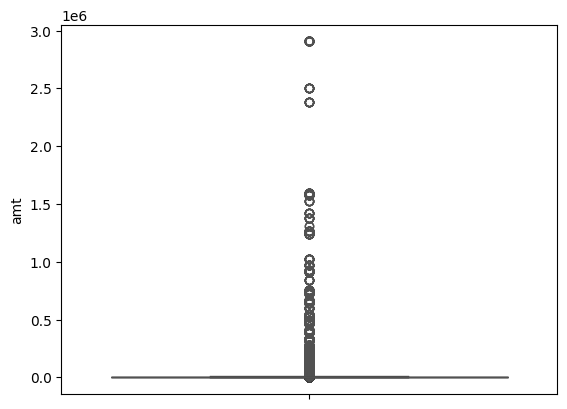

In [ ]:
sns.boxplot(y='amt',data=train_data)
sns.boxplot(y='city_pop',data=train_data)
plt.show()

In [ ]:
amt_log_transformed=np.log1p(train_data['amt'])
amt_log_transformed_df=amt_log_transformed.reset_index()


city_pop_log_transformed=np.log1p(train_data['city_pop'])
city_pop_log_transformed_df=city_pop_log_transformed.reset_index()


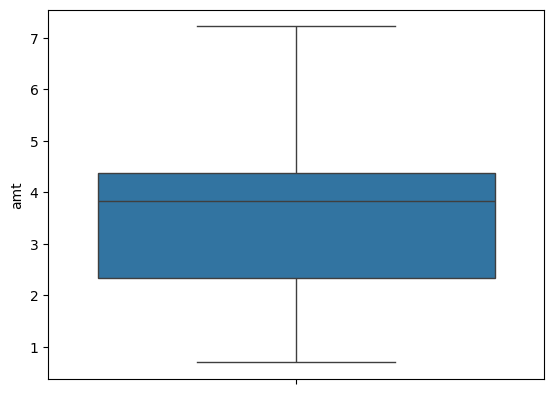

In [ ]:
sns.boxplot(y='amt',data=amt_log_transformed_df)
plt.show()

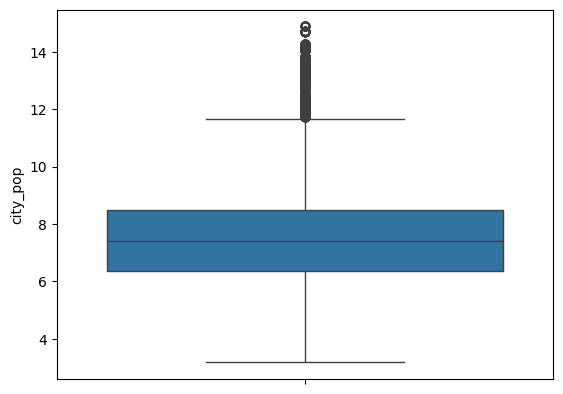

In [ ]:
sns.boxplot(y='city_pop',data=city_pop_log_transformed_df)
plt.show()

In [ ]:
train_data['amt_log_transformed']=amt_log_transformed
train_data['city_pop_log_transformed']=city_pop_log_transformed

In [ ]:
train_data.drop(['amt','city_pop'],axis=1,inplace=True)

In [ ]:
from geopy.distance import geodesic

def calculate_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

In [ ]:
train_data['distance'] = train_data.apply(calculate_distance, axis=1)

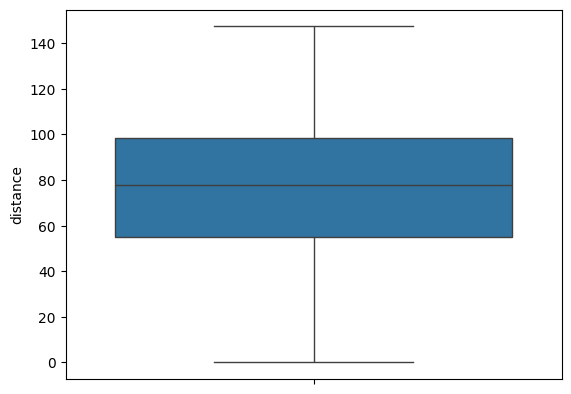

In [ ]:
sns.boxplot(y='distance',data=train_data)
plt.show()

In [ ]:
train_data.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
x=train_data.drop('is_fraud',axis=1)
y=train_data['is_fraud']
x_train,x_test,y_train,y_test= train_test_split(x,y, test_size=0.3, random_state=42)

## Applying Robust Scaler for amount column and city population column

In [ ]:
x_train

,transaction_time_year,gender_encoded,city_encoded,transaction_time_day_sin,transaction_time_day_cos,transaction_time_hour_sin,transaction_time_hour_cos,transaction_time_min_sin,transaction_time_min_cos,transaction_time_sec_sin,transaction_time_sec_cos,transaction_time_month_sin,transaction_time_month_cos,amt_log_transformed,city_pop_log_transformed,distance
210904,2019,1,0.003506,-0.897805,-0.440394,5.000000e-01,-8.660254e-01,0.207912,0.978148,-0.951057,-0.309017,5.000000e-01,-8.660254e-01,3.920190,9.873492,96.083883
502680,2019,1,0.000000,-0.651372,-0.758758,0.000000e+00,1.000000e+00,-0.587785,0.809017,0.500000,0.866025,-8.660254e-01,5.000000e-01,1.593309,9.188606,112.576587
661097,2019,1,0.003394,-0.848644,0.528964,-9.659258e-01,-2.588190e-01,0.000000,1.000000,-0.587785,-0.809017,-2.449294e-16,1.000000e+00,2.368373,10.334328,33.196760
637259,2019,0,0.005410,-0.651372,-0.758758,9.659258e-01,-2.588190e-01,-0.669131,0.743145,-0.406737,0.913545,-2.449294e-16,1.000000e+00,2.262804,6.408529,125.611953
888950,2020,0,0.004431,-0.651372,-0.758758,-2.588190e-01,9.659258e-01,-0.809017,-0.587785,0.951057,-0.309017,5.000000e-01,-8.660254e-01,3.617115,7.554859,72.517643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,2019,1,0.002767,0.299363,-0.954139,-5.000000e-01,8.660254e-01,-0.669131,0.743145,-0.951057,0.309017,1.224647e-16,-1.000000e+00,1.599388,6.142037,60.143480
365838,2019,1,0.003940,0.724793,0.688967,-1.000000e+00,-1.836970e-16,-0.587785,-0.809017,0.309017,0.951057,-8.660254e-01,-5.000000e-01,3.135929,8.613957,51.358597
131932,2019,1,0.004925,0.724793,0.688967,1.224647e-16,-1.000000e+00,0.994522,0.104528,0.309017,0.951057,8.660254e-01,-5.000000e-01,1.479329,8.895356,71.688435
671155,2019,0,0.000000,-0.394356,0.918958,-2.588190e-01,-9.659258e-01,-0.500000,0.866025,-0.500000,0.866025,-2.449294e-16,1.000000e+00,2.568022,7.189168,69.922219


In [ ]:
import joblib
import boto3
from sklearn.preprocessing import RobustScaler
import io  # To handle in-memory file operations

# Initialize S3 client
s3_client = boto3.client("s3")

# Initialize RobustScaler
rs = RobustScaler()
x_train_rob=x_train.copy()
x_test_rob=x_test.copy()
# Fit the scaler on training data and transform
x_train_rob[['amt_log_transformed', 'city_pop_log_transformed']] = rs.fit_transform(x_train_rob[['amt_log_transformed', 'city_pop_log_transformed']])

# Apply the scaler to the test data
x_test_rob[['amt_log_transformed', 'city_pop_log_transformed']] = rs.transform(x_test_rob[['amt_log_transformed', 'city_pop_log_transformed']])


# Save the fitted scaler to a BytesIO object (in-memory file)
scaler_buffer = io.BytesIO()
joblib.dump(rs, scaler_buffer)
scaler_buffer.seek(0)  # Move to the beginning of the buffer

# Upload the pickle file directly to S3
s3_client.put_object(Bucket=bucket_name, Key=rb_sc_key, Body=scaler_buffer.getvalue())

print(f"Scaler saved directly to S3: s3://{bucket_name}/{rb_sc_key}")


Scaler saved directly to S3: s3://credit-card-fraud-detection-system-bucket/robust_scaler.pkl


In [ ]:
x_train_rob['amt_log_transformed']

,amt_log_transformed
58978,-0.537715
609586,-1.091420
1179980,0.452155
906785,0.018450
582605,0.031076
...,...
85817,-1.025882
927356,0.379521
1154789,0.092764
226837,0.086121


## Checking for outliers

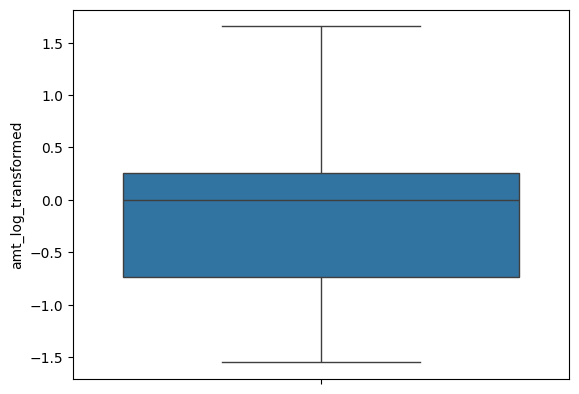

In [ ]:
sns.boxplot(y='amt_log_transformed',data=x_train_rob)
plt.show()

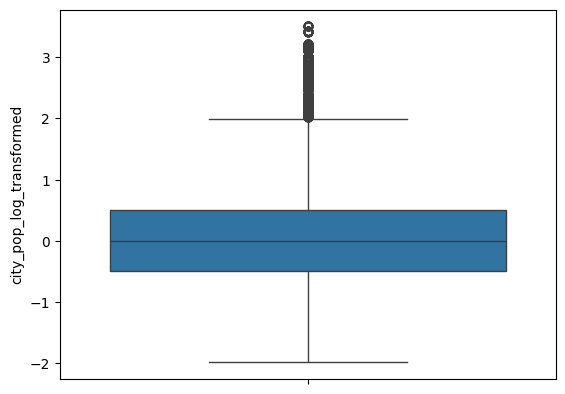

In [ ]:
sns.boxplot(y='city_pop_log_transformed',data=x_train_rob)
plt.show()

In [ ]:
x_train_rob.columns

Index(['transaction_time_year', 'gender_encoded', 'city_encoded',
       'transaction_time_day_sin', 'transaction_time_day_cos',
       'transaction_time_hour_sin', 'transaction_time_hour_cos',
       'transaction_time_min_sin', 'transaction_time_min_cos',
       'transaction_time_sec_sin', 'transaction_time_sec_cos',
       'transaction_time_month_sin', 'transaction_time_month_cos',
       'amt_log_transformed', 'city_pop_log_transformed', 'distance'],
      dtype='object')

In [ ]:
model=LogisticRegression(class_weight='balanced',random_state=42)
model.fit(x_train_rob,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
y_pred=model.predict(x_test_rob)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[236827  49252]
 [   440   1855]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    286079
           1       0.04      0.81      0.07      2295

    accuracy                           0.83    288374
   macro avg       0.52      0.82      0.49    288374
weighted avg       0.99      0.83      0.90    288374



## Testing Decision tree with and without removal of outliers

In [ ]:
dt_model=DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_pred=dt_model.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285600    479]
 [   372   1923]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.80      0.84      0.82      2295

    accuracy                           1.00    288374
   macro avg       0.90      0.92      0.91    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
dt_model=DecisionTreeClassifier(class_weight='balanced')
dt_model.fit(x_train,y_train)
y_pred=dt_model.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285701    378]
 [   386   1909]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.83      0.83      0.83      2295

    accuracy                           1.00    288374
   macro avg       0.92      0.92      0.92    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
def objective(trial):
  smote_params={
        'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
        'k_neighbors':trial.suggest_int('k_neighbors',1,30)
  }
  smote=SMOTE(random_state=42,**smote_params)
  x_train_res,y_train_res=smote.fit_resample(x_train,y_train)
  dt_params={
    'criterion':trial.suggest_categorical('criterion',['gini','entropy','log_loss']),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'min_samples_split':trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,5),
    'max_features':trial.suggest_categorical('max_features',['sqrt','log2'])
  }
  model=DecisionTreeClassifier(random_state=42,class_weight={0:1,1:10},**dt_params)
  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  score=cross_val_score(model,x_train_res,y_train_res,cv=cv,scoring='average_precision',n_jobs=-1).mean()
  return score
study=optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(),pruner=optuna.pruners.MedianPruner())
study.optimize(objective,n_trials=10,n_jobs=1)
dt_best_params=study.best_params
print("Best parameters: ",dt_best_params)
print("Best score: ",study.best_value)

[I 2025-04-01 11:30:29,153] A new study created in memory with name: no-name-ef5a424c-5fa7-42b6-839e-ce822a1d8588
[I 2025-04-01 11:30:32,386] Trial 0 finished with value: 0.9494696309356417 and parameters: {'sampling_strategy': 0.5223614563361431, 'k_neighbors': 18, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9494696309356417.
[I 2025-04-01 11:30:34,666] Trial 1 finished with value: 0.7067803609630741 and parameters: {'sampling_strategy': 0.6679202158426447, 'k_neighbors': 5, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9494696309356417.
[I 2025-04-01 11:30:38,973] Trial 2 finished with value: 0.98325445987075 and parameters: {'sampling_strategy': 0.7559178473122008, 'k_neighbors': 27, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. 

Best parameters:  {'sampling_strategy': 0.7559178473122008, 'k_neighbors': 27, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best score:  0.98325445987075


In [ ]:
smote=SMOTE(sampling_strategy=dt_best_params['sampling_strategy'],k_neighbors=dt_best_params['k_neighbors'],random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train,y_train)
dt_best_params={param:v for param,v in dt_best_params.items() if param not in ['sampling_strategy','k_neighbors']}
dt_model=DecisionTreeClassifier(random_state=42,class_weight={0:1,1:10},**dt_best_params)
dt_model.fit(x_train_res,y_train_res)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[285701    378]
 [   386   1909]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.83      0.83      0.83      2295

    accuracy                           1.00    288374
   macro avg       0.92      0.92      0.92    288374
weighted avg       1.00      1.00      1.00    288374

0.9973506626811016


## Getting the feature importances

In [ ]:
#from here execute
from sklearn.inspection import permutation_importance
perm_importance=permutation_importance(dt_model,x_test,y_test,n_repeats=10)
importance_df=pd.DataFrame({'feature':x_test.columns,'importance':perm_importance.importances_mean})
importance_df.sort_values(by='importance',ascending=False,inplace=True)
print(importance_df.sort_values(by='importance',ascending=False))

                       feature  importance
7    transaction_time_hour_sin    0.048686
8    transaction_time_hour_cos    0.039523
2             category_encoded    0.023961
15         amt_log_transformed    0.017238
14  transaction_time_month_cos    0.005788
13  transaction_time_month_sin    0.005009
4                 city_encoded    0.003464
1               gender_encoded    0.002595
16    city_pop_log_transformed    0.002237
10    transaction_time_min_cos    0.000130
5     transaction_time_day_sin    0.000111
0        transaction_time_year    0.000108
6     transaction_time_day_cos    0.000096
3                state_encoded    0.000063
17                    distance    0.000006
12    transaction_time_sec_cos    0.000000
9     transaction_time_min_sin   -0.000002
11    transaction_time_sec_sin   -0.000004


In [ ]:
importance_df[(importance_df['importance'] > 0.01)]

,feature,importance
7,transaction_time_hour_sin,0.048686
8,transaction_time_hour_cos,0.039523
2,category_encoded,0.023961
15,amt_log_transformed,0.017238


In [ ]:
importance_df[(importance_df['importance'] > 0.01)]

,feature,importance
7,transaction_time_hour_sin,0.048686
8,transaction_time_hour_cos,0.039523
2,category_encoded,0.023961
15,amt_log_transformed,0.017238


In [ ]:
important_columns_dt=importance_df[(importance_df['importance'] > 0.01)].columns

In [ ]:
from joblib import parallel_backend
rf_model=RandomForestClassifier()
#smote=SMOTE(random_state=42)
#x_train_res,y_train_res=smote.fit_resample(x_train,y_train)
rf_model.fit(x_train,y_train)
y_pred=rf_model.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286079      0]
 [   401   1894]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       1.00      0.83      0.90      2295

    accuracy                           1.00    288374
   macro avg       1.00      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
from sklearn.inspection import permutation_importance
perm_importance=permutation_importance(rf_model,x_test,y_test,n_repeats=10)
importance_df=pd.DataFrame({'feature':x_test.columns,'importance':perm_importance.importances_mean})
importance_df.sort_values(by='importance',ascending=False,inplace=True)
print(importance_df.sort_values(by='importance',ascending=False))

                       feature    importance
15         amt_log_transformed  1.787124e-02
7    transaction_time_hour_sin  4.603050e-03
8    transaction_time_hour_cos  3.662952e-03
2             category_encoded  2.892424e-03
16    city_pop_log_transformed  1.697448e-03
4                 city_encoded  6.983986e-04
13  transaction_time_month_sin  4.646743e-05
14  transaction_time_month_cos  3.363687e-05
0        transaction_time_year  1.352410e-05
6     transaction_time_day_cos  7.628982e-06
5     transaction_time_day_sin  5.895122e-06
3                state_encoded  6.935438e-07
1               gender_encoded -3.814491e-06
17                    distance -5.201579e-06
11    transaction_time_sec_sin -6.588666e-06
12    transaction_time_sec_cos -1.317733e-05
10    transaction_time_min_cos -1.525796e-05
9     transaction_time_min_sin -1.664505e-05


In [ ]:
#shap values
import shap
explainer=shap.TreeExplainer(rf_model)
shap_values=explainer.shap_values(x_test)
shap.summary_plot(shap_values,x_test)

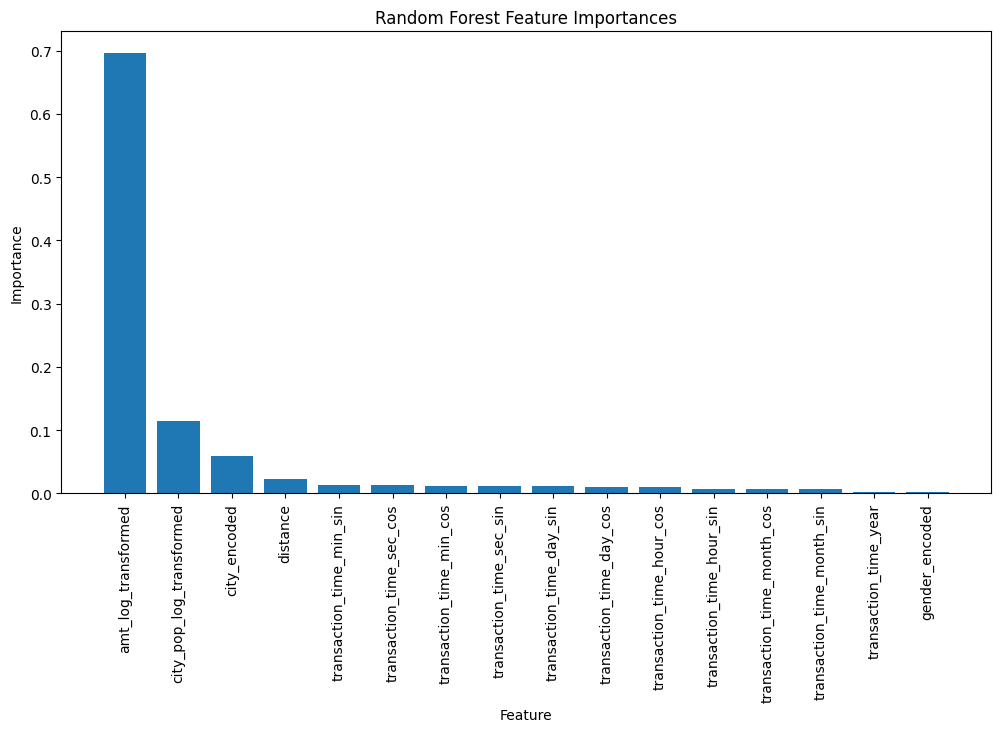

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importances
importances = rf_model.feature_importances_

# Get feature names
features = x_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
feature_importances={}
for i in indices:
  feature_importances[features[i]]=importances[i]
# Convert np.float64 to standard Python float
feature_importances = {key: float(value) for key, value in feature_importances.items()}

# Print the updated dictionary
for i,v in feature_importances.items():
  print(i," : ",v)


amt_log_transformed  :  0.6957160577472317
city_pop_log_transformed  :  0.11524468285577183
city_encoded  :  0.05992871383315969
distance  :  0.02267567629691073
transaction_time_min_sin  :  0.012808199749171587
transaction_time_sec_cos  :  0.012635976592249014
transaction_time_min_cos  :  0.012532604838404737
transaction_time_sec_sin  :  0.012496717737939733
transaction_time_day_sin  :  0.011432869577578102
transaction_time_day_cos  :  0.010248957601448117
transaction_time_hour_cos  :  0.009812623190722784
transaction_time_hour_sin  :  0.006940766728665634
transaction_time_month_cos  :  0.006765691534352843
transaction_time_month_sin  :  0.006487922136191832
transaction_time_year  :  0.002268660961376626
gender_encoded  :  0.002003878618825029


## Keep only the important features and discard the rest of the features

In [ ]:
train_original.columns

Index(['lat', 'long', 'merch_lat', 'merch_long', 'is_fraud',
       'transaction_time_year', 'gender_encoded', 'category_encoded',
       'state_encoded', 'city_encoded', 'transaction_time_day_sin',
       'transaction_time_day_cos', 'transaction_time_hour_sin',
       'transaction_time_hour_cos', 'transaction_time_min_sin',
       'transaction_time_min_cos', 'transaction_time_sec_sin',
       'transaction_time_sec_cos', 'transaction_time_month_sin',
       'transaction_time_month_cos', 'amt_log_transformed',
       'city_pop_log_transformed'],
      dtype='object')

In [ ]:
importance_threshold = 0.01
important_columns = [col for col, imp in feature_importances.items() if imp >= importance_threshold]

print("Selected important columns:", important_columns)

# Ensure the target column is not mistakenly included
important_columns = [col for col in important_columns if col != 'is_fraud']

x_train_imp = x_train[important_columns]
x_test_imp = x_test[important_columns]
important_columns

Selected important columns: ['amt_log_transformed', 'city_pop_log_transformed', 'city_encoded', 'distance', 'transaction_time_min_sin', 'transaction_time_sec_cos', 'transaction_time_min_cos', 'transaction_time_sec_sin', 'transaction_time_day_sin', 'transaction_time_day_cos']


['amt_log_transformed',
 'city_pop_log_transformed',
 'city_encoded',
 'distance',
 'transaction_time_min_sin',
 'transaction_time_sec_cos',
 'transaction_time_min_cos',
 'transaction_time_sec_sin',
 'transaction_time_day_sin',
 'transaction_time_day_cos']

In [ ]:
x_train_imp.columns

Index(['amt_log_transformed', 'city_pop_log_transformed', 'city_encoded',
       'distance', 'transaction_time_min_sin', 'transaction_time_sec_cos',
       'transaction_time_min_cos', 'transaction_time_sec_sin',
       'transaction_time_day_sin', 'transaction_time_day_cos'],
      dtype='object')

In [ ]:
dt_model_original=DecisionTreeClassifier(random_state=42)
dt_model_original.fit(x_train_imp,y_train)
y_pred=dt_model_original.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285502    577]
 [   385   1910]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.77      0.83      0.80      2295

    accuracy                           1.00    288374
   macro avg       0.88      0.92      0.90    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
dt_model_bal=DecisionTreeClassifier(class_weight='balanced',random_state=42)
dt_model_bal.fit(x_train_imp,y_train)
y_pred=dt_model_bal.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285675    404]
 [   395   1900]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.82      0.83      0.83      2295

    accuracy                           1.00    288374
   macro avg       0.91      0.91      0.91    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
smote=SMOTE(random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)
rf_model_original=RandomForestClassifier(random_state=42,n_jobs=-1)
rf_model_original.fit(x_train_res,y_train_res)
y_pred=rf_model_original.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286076      3]
 [   401   1894]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       1.00      0.83      0.90      2295

    accuracy                           1.00    288374
   macro avg       1.00      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=train_data['is_fraud'].values)
rf_model_bal = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=42,n_jobs=-1)
rf_model_bal.fit(x_train_imp,y_train)
y_pred=rf_model_bal.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286079      0]
 [   405   1890]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       1.00      0.82      0.90      2295

    accuracy                           1.00    288374
   macro avg       1.00      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



## Implementing SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)

In [ ]:
unique,counts=np.unique(y_train_res,return_counts=True)
unique,counts

(array([0, 1]), array([902451, 902451]))

In [ ]:
x_train

,transaction_time_year,gender_encoded,category_encoded,state_encoded,city_encoded,transaction_time_day_sin,transaction_time_day_cos,transaction_time_hour_sin,transaction_time_hour_cos,transaction_time_min_sin,transaction_time_min_cos,transaction_time_sec_sin,transaction_time_sec_cos,transaction_time_month_sin,transaction_time_month_cos,amt_log_transformed,city_pop_log_transformed,distance
0,2020,1,0.017561,0.005443,0.005094,0.968077,-0.250653,-0.965926,2.588190e-01,-0.406737,0.913545,0.309017,9.510565e-01,8.660254e-01,5.000000e-01,1.217876,6.336826,30.051992
1,2019,0,0.007225,0.005693,0.005469,0.790776,-0.612106,-0.866025,5.000000e-01,0.866025,0.500000,0.809017,5.877853e-01,-2.449294e-16,1.000000e+00,2.018895,10.238959,90.407003
2,2019,1,0.017561,0.005149,0.000000,0.790776,-0.612106,-0.866025,-5.000000e-01,-0.104528,0.994522,-0.951057,3.090170e-01,-8.660254e-01,-5.000000e-01,2.030776,10.074411,80.508236
3,2019,0,0.014458,0.006769,0.007874,-0.394356,0.918958,0.866025,-5.000000e-01,0.809017,-0.587785,0.978148,2.079117e-01,1.000000e+00,6.123234e-17,3.252697,11.662689,34.088939
4,2019,0,0.001608,0.005428,0.000970,-0.724793,0.688967,-0.500000,-8.660254e-01,-0.978148,0.207912,0.500000,8.660254e-01,-5.000000e-01,-8.660254e-01,3.282789,9.887663,78.916112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907667,2019,0,0.004694,0.005550,0.006661,0.724793,0.688967,0.500000,8.660254e-01,-0.913545,0.406737,0.207912,-9.781476e-01,1.000000e+00,6.123234e-17,4.295651,7.299121,106.949084
907668,2019,0,0.003139,0.002077,0.010622,0.968077,-0.250653,1.000000,6.123234e-17,-0.587785,0.809017,0.406737,9.135455e-01,5.000000e-01,-8.660254e-01,1.202972,8.601350,113.299905
907669,2019,0,0.001608,0.004998,0.000000,0.485302,-0.874347,-0.707107,7.071068e-01,-0.994522,0.104528,0.309017,-9.510565e-01,1.000000e+00,6.123234e-17,4.781390,5.739793,35.676108
907670,2019,1,0.007225,0.006527,0.010557,0.485302,-0.874347,0.707107,-7.071068e-01,0.207912,-0.978148,0.406737,-9.135455e-01,-8.660254e-01,5.000000e-01,1.887070,4.948760,116.671920


## Training random forest with smote + classweight

In [ ]:
rf_model_smote=RandomForestClassifier(class_weight='balanced_subsample',random_state=42,n_jobs=-1)
rf_model_smote.fit(x_train_res,y_train_res)
y_pred=rf_model_smote.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[299925  86793]
 [   286   1999]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.87    386718
           1       0.02      0.87      0.04      2285

    accuracy                           0.78    389003
   macro avg       0.51      0.83      0.46    389003
weighted avg       0.99      0.78      0.87    389003



In [ ]:
accuracy_score(y_test,y_pred)

0.9977840787860248

In [ ]:
import joblib
from io import BytesIO


model_key='rf_model_smote_weight.pkl'
buffer=BytesIO() #acts as a buffer to avoid saving the file locally
joblib.dump(rf_model_smote,buffer)
buffer.seek(0)

s3_client.put_object(Bucket=bucket_name,Key=model_key,Body=buffer.getvalue())

# Save the model locally using joblib
#joblib.dump(rf_model, 'smote_rf_model.h5')
#joblib.dump(rf_model, 'smote_rf_model.pkl')

{'ResponseMetadata': {'RequestId': 'M4TJGND6P62WK8V0',
  'HostId': 'D2+EDtY0ACQwbwR1YP1KVtZ30GbZu4NiTQh7jm2uQ19ksDxrSR0J4qFhik7wIA1Na+gqbCSmCvk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'D2+EDtY0ACQwbwR1YP1KVtZ30GbZu4NiTQh7jm2uQ19ksDxrSR0J4qFhik7wIA1Na+gqbCSmCvk=',
   'x-amz-request-id': 'M4TJGND6P62WK8V0',
   'date': 'Sun, 30 Mar 2025 17:45:40 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"f209d96b2ab1a3be6aec370368d5eec5"',
   'x-amz-checksum-crc32': 'cVY0Ug==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"f209d96b2ab1a3be6aec370368d5eec5"',
 'ChecksumCRC32': 'cVY0Ug==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

## Applying Hyperparameter tuning to Random Forest Classifier using optuna

In [ ]:
def objective(trial):
  # parameters of smote
  smote_params={
      'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
      'k_neighbors':trial.suggest_int('k_neighbors',1,30)
  }

  smote=SMOTE(random_state=42,**smote_params)
  x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)
  #parameters of random forest
  rf_params={
    'n_estimators':trial.suggest_int('n_estimators',50,300),
    'criterion':trial.suggest_categorical('criterion',['gini','log_loss','entropy']),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'min_samples_split':trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,5),
    'max_features':trial.suggest_categorical('max_features',['sqrt','log2'])
  }

  model=RandomForestClassifier(random_state=42,
                               warm_start=True,
                               n_jobs=-1,**rf_params)
  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores=cross_val_score(model,
                         x_train_res,y_train_res,
                         cv=cv,
                         scoring='average_precision',
                         n_jobs=-1).mean()
  return scores

study=optuna.create_study(direction='maximize',
                          sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner())
study.optimize(objective,n_trials=10,n_jobs=1)

print("Best parameters: ",study.best_params)
print("Best score: ",study.best_value)

[I 2025-04-01 13:13:06,938] A new study created in memory with name: no-name-5ea6caed-459c-4f57-acc9-092df30a2417
[I 2025-04-01 13:19:07,339] Trial 0 finished with value: 0.9894708143768194 and parameters: {'sampling_strategy': 0.5560732513959608, 'k_neighbors': 25, 'n_estimators': 269, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9894708143768194.
[I 2025-04-01 13:20:34,414] Trial 1 finished with value: 0.984313778091528 and parameters: {'sampling_strategy': 0.6271019216710075, 'k_neighbors': 19, 'n_estimators': 82, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9894708143768194.
[I 2025-04-01 13:24:04,650] Trial 2 finished with value: 0.9836179378233384 and parameters: {'sampling_strategy': 0.5443494907381733, 'k_neighbors': 15, 'n_estimators': 213, 'criterion': 'gini', 'max_depth': 6, 'min_samples_sp

Best parameters:  {'sampling_strategy': 0.9699504821901785, 'k_neighbors': 17, 'n_estimators': 115, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best score:  0.9931107201397744


In [ ]:
rf_model_params=study.best_params
smote=SMOTE(sampling_strategy=rf_model_params['sampling_strategy'],
            k_neighbors=rf_model_params['k_neighbors'],
            random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)
rf_model=RandomForestClassifier(n_estimators=rf_model_params['n_estimators'],
                                      criterion=rf_model_params['criterion'],
                                      max_depth=rf_model_params['max_depth'],
                                      min_samples_split=rf_model_params['min_samples_split'],
                                      min_samples_leaf=rf_model_params['min_samples_leaf'],
                                      max_features=rf_model_params['max_features'],
                                      random_state=42)
rf_model.fit(x_train_imp,y_train)
y_pred=rf_model.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286079      0]
 [   401   1894]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       1.00      0.83      0.90      2295

    accuracy                           1.00    288374
   macro avg       1.00      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
def objective(trial):
  # parameters of smote
  rus_params={
      'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
      }


  rus=RandomUnderSampler(random_state=42,**rus_params)
  x_train_res,y_train_res=rus.fit_resample(x_train_imp,y_train)

  #parameters of random forest
  rf_us_params={
    'n_estimators':trial.suggest_int('n_estimators',50,200),
    'criterion':trial.suggest_categorical('criterion',['gini','log_loss','entropy']),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'min_samples_split':trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,5),
    'max_features':trial.suggest_categorical('max_features',['sqrt','log2',None])
  }

  model=RandomForestClassifier(random_state=42,warm_start=True,n_jobs=-1,**rf_us_params)

  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores=cross_val_score(model,x_train_res,y_train_res,cv=cv,scoring='average_precision',n_jobs=-1).mean()
  return scores

study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20,n_jobs=1)

print("Best parameters: ",study.best_params)
print("Best score: ",study.best_value)

[I 2025-04-01 11:47:32,559] A new study created in memory with name: no-name-3c0b2dfe-ca60-4595-88d4-baa8fb7213e6
[I 2025-04-01 11:47:35,002] Trial 0 finished with value: 0.9711173209095323 and parameters: {'sampling_strategy': 0.5156862912507107, 'n_estimators': 103, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9711173209095323.
[I 2025-04-01 11:47:36,362] Trial 1 finished with value: 0.9367818447940234 and parameters: {'sampling_strategy': 0.7427654092049838, 'n_estimators': 88, 'criterion': 'log_loss', 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.9711173209095323.
[I 2025-04-01 11:47:38,039] Trial 2 finished with value: 0.9822400835122929 and parameters: {'sampling_strategy': 0.7956179110062186, 'n_estimators': 176, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features'

Best parameters:  {'sampling_strategy': 0.9467984750178731, 'n_estimators': 112, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Best score:  0.9865090851970317


In [ ]:
rf_trial=study.best_trial.params
rf_trial

{'sampling_strategy': 0.9467984750178731,
 'n_estimators': 112,
 'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None}

In [ ]:
sampling_strategy = rf_trial.pop('sampling_strategy')

In [ ]:
rus=RandomUnderSampler(random_state=42,sampling_strategy=sampling_strategy)
x_train_res,y_train_res=rus.fit_resample(x_train_imp,y_train)
rf_model_und=RandomForestClassifier(random_state=42,warm_start=True,**rf_trial,n_jobs=-1)
rf_model_und.fit(x_train_res,y_train_res)
y_pred=rf_model_und.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[274117  11962]
 [   213   2082]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    286079
           1       0.15      0.91      0.25      2295

    accuracy                           0.96    288374
   macro avg       0.57      0.93      0.62    288374
weighted avg       0.99      0.96      0.97    288374



In [ ]:
import joblib
from io import BytesIO


model_key='rf_model_undersampled.pkl'
buffer=BytesIO() #acts as a buffer to avoid saving the file locally
joblib.dump(rf_model,buffer)
buffer.seek(0)

s3_client.put_object(Bucket=bucket_name,Key=model_key,Body=buffer.getvalue())

# Save the model using joblib
#joblib.dump(rf_model, 'best_rf_model.h5')
#joblib.dump(rf_model, 'best_rf_model.pkl')

{'ResponseMetadata': {'RequestId': '771Q3XDCBW2AKC6D',
  'HostId': 'bBE/kCaQxexHBX+NChx6unvNZL+0V6+uHYPcDY9Mgjlk3mLCnT/8z4j5W++adEkMZM12rj/fg1U=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'bBE/kCaQxexHBX+NChx6unvNZL+0V6+uHYPcDY9Mgjlk3mLCnT/8z4j5W++adEkMZM12rj/fg1U=',
   'x-amz-request-id': '771Q3XDCBW2AKC6D',
   'date': 'Tue, 01 Apr 2025 11:48:39 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"cb64596197c07dceb3a14469ddb3c0e4"',
   'x-amz-checksum-crc32': 'cPpo7w==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"cb64596197c07dceb3a14469ddb3c0e4"',
 'ChecksumCRC32': 'cPpo7w==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

## Random forest hyperparameter tuning using near miss method

In [ ]:
#from here execute
def objective(trial):
  # parameters of smote
  near_miss_params={
      'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
      'n_neighbors':trial.suggest_int('n_neighbors',1,25,step=2),
      'n_neighbors_ver3':trial.suggest_int('n_neighbors_ver3',1,25,step=2),
      }


  nm=NearMiss(**near_miss_params)
  x_train_res,y_train_res=nm.fit_resample(x_train_imp,y_train)

  #parameters of random forest
  rf_us_params={
    'n_estimators':trial.suggest_int('n_estimators',50,300),
    'criterion':trial.suggest_categorical('criterion',['gini','log_loss','entropy']),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'min_samples_split':trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,5),
    'max_features':trial.suggest_categorical('max_features',['sqrt','log2',None])
  }

  model=RandomForestClassifier(random_state=42,warm_start=True,n_jobs=-1,**rf_us_params)

  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores=cross_val_score(model,x_train_res,y_train_res,cv=cv,scoring='average_precision',n_jobs=-1).mean()
  return scores

study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20,n_jobs=1)

print("Best parameters: ",study.best_params)
print("Best score: ",study.best_value)

[I 2025-04-01 11:49:07,102] A new study created in memory with name: no-name-0a0bc4f8-d3fc-4ace-8817-3cf934049927
[I 2025-04-01 11:49:15,107] Trial 0 finished with value: 0.9885924627059104 and parameters: {'sampling_strategy': 0.8166134172559739, 'n_neighbors': 15, 'n_neighbors_ver3': 13, 'n_estimators': 83, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.9885924627059104.
[I 2025-04-01 11:49:21,445] Trial 1 finished with value: 0.9788306822260943 and parameters: {'sampling_strategy': 0.705524503635502, 'n_neighbors': 5, 'n_neighbors_ver3': 23, 'n_estimators': 159, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9885924627059104.
[I 2025-04-01 11:49:28,885] Trial 2 finished with value: 0.9847741859599968 and parameters: {'sampling_strategy': 0.8659994676328818, 'n_neighbors': 7, 'n_neighbors_ver3': 5, 

Best parameters:  {'sampling_strategy': 0.6077654594528679, 'n_neighbors': 25, 'n_neighbors_ver3': 1, 'n_estimators': 264, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}
Best score:  0.9974601885229053


In [ ]:
rf_params=study.best_trial.params
rf_params

{'sampling_strategy': 0.6077654594528679,
 'n_neighbors': 25,
 'n_neighbors_ver3': 1,
 'n_estimators': 264,
 'criterion': 'log_loss',
 'max_depth': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': None}

In [ ]:
near_miss_params = {key: rf_params.pop(key) for key in ['sampling_strategy', 'n_neighbors', 'n_neighbors_ver3']}

# Output the dictionary with the popped parameters
print(near_miss_params)

{'sampling_strategy': 0.6077654594528679, 'n_neighbors': 25, 'n_neighbors_ver3': 1}


In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit(x_train_imp)
x_train_imp_sc=sc.transform(x_train_imp)
x_test_imp_sc=sc.transform(x_test_imp)

In [ ]:
nm=SMOTE(random_state=42)
x_train_res,y_train_res=nm.fit_resample(x_train_imp_sc,y_train)
rf_model_smote_scaled=RandomForestClassifier(random_state=42,warm_start=True,**rf_params)
rf_model_smote_scaled.fit(x_train_res,y_train_res)
y_pred=rf_model_smote_scaled.predict(x_test_imp_sc)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

KeyboardInterrupt: 

## Fitting Light gradient boosing with default parameters

In [ ]:
lgbm_model_original=LGBMClassifier(random_state=42)
lgbm_model_original.fit(x_train_imp,y_train)
y_pred=lgbm_model_original.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 5211, number of negative: 667661
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 672872, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007744 -> initscore=-4.853009
[LightGBM] [Info] Start training from score -4.853009
[[285844    235]
 [   523   1772]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.88      0.77      0.82      2295

    accuracy                           1.00    288374
   macro avg       0.94      0.89      0.91    288374
weighted avg       1.00      1.00      1.00    288374



## Fitting Light gradient boosting with default parameters by using smote

In [ ]:
smote=SMOTE(random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)

lgbm_model_smote=LGBMClassifier(random_state=42)
lgbm_model_smote.fit(x_train_res,y_train_res)
y_pred=lgbm_model_smote.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 902451, number of negative: 902451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1804902, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[386427    291]
 [   522   1763]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.86      0.77      0.81      2285

    accuracy                           1.00    389003
   macro avg       0.93      0.89      0.91    389003
weighted avg       1.00      1.00      1.00    389003



In [ ]:
y_pred_proba=lgbm_model_smote.predict_proba(x_test_imp)[:,1]

y_pred_adjusted_smote=(y_pred_proba >= 0.3).astype(int)
print(confusion_matrix(y_test,y_pred_adjusted_smote))
print(classification_report(y_test,y_pred_adjusted_smote))

[[386103    615]
 [   392   1893]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.75      0.83      0.79      2285

    accuracy                           1.00    389003
   macro avg       0.88      0.91      0.89    389003
weighted avg       1.00      1.00      1.00    389003



In [ ]:
import optuna
def objective(trial):
  # parameters of smote
  smote_params={
      'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
      'k_neighbors':trial.suggest_int('k_neighbors',1,30)
      }


  smote=SMOTE(random_state=42,**smote_params)
  x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)

  #parameters of random forest
  lgbm_params={
    'n_estimators':trial.suggest_int('n_estimators',50,200),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'num_leaves':trial.suggest_int('num_leaves',20,50),
    'reg_alpha':trial.suggest_float('reg_alpha',0.0,10.0),
    'reg_lambda':trial.suggest_float('reg_lambda',0.0,10.0),

  }

  model=LGBMClassifier(random_state=42,**lgbm_params)

  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores=cross_val_score(model,x_train_res,y_train_res,cv=cv,scoring='average_precision',n_jobs=-1).mean()
  return scores

study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20,n_jobs=1)

print("Best parameters: ",study.best_params)
print("Best score: ",study.best_value)

[I 2025-02-07 13:07:07,670] A new study created in memory with name: no-name-6bf8f263-9143-4c63-b2f7-c8a918e76ce1
[I 2025-02-07 13:10:04,417] Trial 0 finished with value: 0.9999806680066466 and parameters: {'sampling_strategy': 0.5246221285130132, 'k_neighbors': 30, 'n_estimators': 181, 'max_depth': 10, 'num_leaves': 33, 'reg_alpha': 1.681268115291078, 'reg_lambda': 7.303783281867828}. Best is trial 0 with value: 0.9999806680066466.
[I 2025-02-07 13:11:44,432] Trial 1 finished with value: 0.9999661318014365 and parameters: {'sampling_strategy': 0.879514885301103, 'k_neighbors': 26, 'n_estimators': 123, 'max_depth': 6, 'num_leaves': 37, 'reg_alpha': 4.595949084205214, 'reg_lambda': 4.556759273333052}. Best is trial 0 with value: 0.9999806680066466.
[I 2025-02-07 13:12:27,160] Trial 2 finished with value: 0.9953861489546894 and parameters: {'sampling_strategy': 0.5678447674696036, 'k_neighbors': 28, 'n_estimators': 100, 'max_depth': 2, 'num_leaves': 42, 'reg_alpha': 6.513445678201046, 'r

Best parameters:  {'sampling_strategy': 0.9434947969016936, 'k_neighbors': 17, 'n_estimators': 167, 'max_depth': 7, 'num_leaves': 41, 'reg_alpha': 8.901009796677268, 'reg_lambda': 3.138490352429592}
Best score:  0.9999870652439931


In [ ]:
lgbm_params=study.best_params
smote=SMOTE(sampling_strategy=lgbm_params['sampling_strategy'],
            random_state=42,
            k_neighbors=lgbm_params['k_neighbors'])
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)
lgbm_model_tuned=LGBMClassifier(n_estimators=lgbm_params['n_estimators'],
                          max_depth=lgbm_params['max_depth'],
                          num_leaves=lgbm_params['num_leaves'],
                          reg_alpha=lgbm_params['reg_alpha'],
                          reg_lambda=lgbm_params['reg_lambda'],
                          random_state=42)
lgbm_model_tuned.fit(x_train_res,y_train_res)
y_pred=lgbm_model_tuned.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 629894, number of negative: 667618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1297512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485463 -> initscore=-0.058165
[LightGBM] [Info] Start training from score -0.058165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred_proba=lgbm_model_tuned.predict_proba(x_test_imp)[:,1]
precisions,recalls,thresholds=precision_recall_curve(y_test,y_pred_proba)
f1_scores=(2*precisions*recalls)/(precisions+recalls)
best_threshold=thresholds[np.argmax(f1_scores)]
best_threshold

0.425239855970734

In [ ]:
y_pred=(y_pred_proba>=0.18).astype(int)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285750    372]
 [   212   2040]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286122
           1       0.85      0.91      0.87      2252

    accuracy                           1.00    288374
   macro avg       0.92      0.95      0.94    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
model_key='lgbm_model_smote.pkl'
buffer=BytesIO()
joblib.dump(lgbm_model_smote,buffer)
buffer.seek(0)

s3_client.upload_fileobj(buffer,bucket_name,model_key)

## Hyperparameter tuning LGBMClassifier using ADASYN over sampling method

In [ ]:
import optuna
from imblearn.over_sampling import ADASYN
def objective(trial):
  # parameters of smote
  adasyn_params={
      #'sampling_strategy':trial.suggest_float('sampling_strategy',0.5,1.0),
      'n_neighbors':trial.suggest_int('n_neighbors',1,30)
      }


  adasyn=ADASYN(random_state=42,**adasyn_params)
  x_train_res,y_train_res=adasyn.fit_resample(x_train_imp,y_train)

  #parameters of random forest
  lgbm_params={
    'n_estimators':trial.suggest_int('n_estimators',50,200),
    'max_depth':trial.suggest_int('max_depth',1,10),
    'num_leaves':trial.suggest_int('num_leaves',20,50),
    'reg_alpha':trial.suggest_float('reg_alpha',0.0,10.0),
    'reg_lambda':trial.suggest_float('reg_lambda',0.0,10.0),

  }

  model=LGBMClassifier(random_state=42,**lgbm_params)

  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scores=cross_val_score(model,x_train_res,y_train_res,cv=cv,scoring='average_precision',n_jobs=-1).mean()
  return scores

study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=20,n_jobs=1)

print("Best parameters: ",study.best_params)
print("Best score: ",study.best_value)

[I 2025-02-07 13:59:17,582] A new study created in memory with name: no-name-55bc5778-549e-4e0c-8a30-cd67f29645ee
[I 2025-02-07 14:01:26,059] Trial 0 finished with value: 0.9999709573112897 and parameters: {'n_neighbors': 18, 'n_estimators': 157, 'max_depth': 5, 'num_leaves': 30, 'reg_alpha': 1.0138793145676706, 'reg_lambda': 2.3009499856264504}. Best is trial 0 with value: 0.9999709573112897.
[I 2025-02-07 14:03:28,318] Trial 1 finished with value: 0.9999537147744176 and parameters: {'n_neighbors': 16, 'n_estimators': 168, 'max_depth': 4, 'num_leaves': 28, 'reg_alpha': 8.700466096794553, 'reg_lambda': 1.6322500436897414}. Best is trial 0 with value: 0.9999709573112897.
[I 2025-02-07 14:05:19,616] Trial 2 finished with value: 0.9999762200499855 and parameters: {'n_neighbors': 18, 'n_estimators': 111, 'max_depth': 7, 'num_leaves': 36, 'reg_alpha': 9.838462520949614, 'reg_lambda': 8.378545960184066}. Best is trial 2 with value: 0.9999762200499855.
[I 2025-02-07 14:07:46,135] Trial 3 fini

Best parameters:  {'n_neighbors': 5, 'n_estimators': 194, 'max_depth': 9, 'num_leaves': 21, 'reg_alpha': 1.598863394850265, 'reg_lambda': 0.1002181997917348}
Best score:  0.9999880291396407


In [ ]:
lgbm_adasyn_params=study.best_params
adasyn=ADASYN(#sampling_strategy=lgbm_params['sampling_strategy'],
              n_neighbors=lgbm_adasyn_params['n_neighbors'],
              random_state=42)
x_train_res,y_train_res=adasyn.fit_resample(x_train_imp,y_train)

lgbm_model_adasyn=LGBMClassifier(n_estimators=lgbm_adasyn_params['n_estimators'],
                          max_depth=lgbm_adasyn_params['max_depth'],
                          num_leaves=lgbm_adasyn_params['num_leaves'],
                          reg_alpha=lgbm_adasyn_params['reg_alpha'],
                          reg_lambda=lgbm_adasyn_params['reg_lambda'],
                          random_state=42)
lgbm_model_adasyn.fit(x_train_res,y_train_res)
y_pred=lgbm_model_adasyn.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 668276, number of negative: 667618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1335894, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500246 -> initscore=0.000985
[LightGBM] [Info] Start training from score 0.000985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[[286113      9]
 [   296   1956]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286122
           1       1.00      0.87      0.93      2252

    a

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred_proba=lgbm_model_adasyn.predict_proba(x_test_imp)[:,1]

precisions,recalls,thresholds=precision_recall_curve(y_test,y_pred_proba)
f1_scores=(2*precisions*recalls)/(precisions+recalls)
best_threshold=thresholds[np.argmax(f1_scores)]
best_threshold

0.38269304589923125

In [ ]:
y_pred=(y_pred_proba>=0.16).astype(int)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285752    370]
 [   212   2040]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286122
           1       0.85      0.91      0.88      2252

    accuracy                           1.00    288374
   macro avg       0.92      0.95      0.94    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
model_key='lgbm_model_adasyn.pkl'
buffer=BytesIO()
joblib.dump(lgbm_model_adasyn,buffer)
buffer.seek(0)

s3_client.upload_fileobj(buffer,bucket_name,model_key)

## Implementing voting classifier

## Voting classifier using original data

In [ ]:
dt_model=DecisionTreeClassifier(random_state=42)
rf_classifier=RandomForestClassifier(random_state=42,n_jobs=-1)
ada_boost=AdaBoostClassifier(random_state=42)
hist_gb=HistGradientBoostingClassifier(random_state=42)

In [ ]:

voting_classifier=VotingClassifier(estimators=[
    ('dt_model',dt_model),
    ('rf_classifier',rf_classifier),
    ('ada_boost',ada_boost),
    ('hist_gb',hist_gb)
    ],voting='soft')
voting_classifier.fit(x_train_imp,y_train)
y_pred=voting_classifier.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286076      3]
 [   401   1894]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       1.00      0.83      0.90      2295

    accuracy                           1.00    288374
   macro avg       1.00      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
y_pred_proba=voting_classifier.predict_proba(x_test_imp)[:,1]

In [ ]:
y_pred=(y_pred_proba>=0.35).astype(int)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[285831    248]
 [   390   1905]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.88      0.83      0.86      2295

    accuracy                           1.00    288374
   macro avg       0.94      0.91      0.93    288374
weighted avg       1.00      1.00      1.00    288374



## Implementing voting classifier using smote

In [ ]:
smote=SMOTE(random_state=42)
x_train_res,y_train_res=smote.fit_resample(x_train_imp,y_train)

In [ ]:
voting_classifier_smote=VotingClassifier(estimators=[
    ('dt_model',dt_model),
    ('rf_classifier',rf_classifier),
    ('ada_boost',ada_boost),
    ('hist_gb',hist_gb)
    ],voting='soft')
voting_classifier_smote.fit(x_train_res,y_train_res)
y_pred=voting_classifier_smote.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[286062     17]
 [   399   1896]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    286079
           1       0.99      0.83      0.90      2295

    accuracy                           1.00    288374
   macro avg       0.99      0.91      0.95    288374
weighted avg       1.00      1.00      1.00    288374



In [ ]:
y_pred_proba=voting_classifier_smote.predict_proba(x_test_imp)[:,1]
y_pred=(y_pred_proba>=0.35).astype(int)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[284600   1479]
 [   376   1919]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    286079
           1       0.56      0.84      0.67      2295

    accuracy                           0.99    288374
   macro avg       0.78      0.92      0.84    288374
weighted avg       1.00      0.99      0.99    288374



In [ ]:
model_key='voting_classifier_dt_rf_ada.pkl'
buffer=BytesIO()
joblib.dump(voting_classifier,buffer)
buffer.seek(0)
s3_client.upload_fileobj(buffer,bucket_name,model_key)

In [ ]:
model_key='voting_classifier_smote_dt_rf_ada.pkl'
buffer=BytesIO()
joblib.dump(voting_classifier_smote,buffer)
buffer.seek(0)
s3_client.upload_fileobj(buffer,bucket_name,model_key)

In [ ]:
from sklearn.ensemble import IsolationForest #executed
if_model=IsolationForest(random_state=42,n_jobs=-1,)
if_model.fit(x_train_imp,y_train)
y_pred=if_model.predict(x_test_imp)
y_pred=np.where(y_pred==-1,1,0)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[141491 245227]
 [   192   2093]]
              precision    recall  f1-score   support

           0       1.00      0.37      0.54    386718
           1       0.01      0.92      0.02      2285

    accuracy                           0.37    389003
   macro avg       0.50      0.64      0.28    389003
weighted avg       0.99      0.37      0.53    389003



In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier #executed
hgb_classifier=HistGradientBoostingClassifier(random_state=42,class_weight='balanced')
hgb_classifier.fit(x_train_imp,y_train)
y_pred=hgb_classifier.predict(x_test_imp)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[380760   5958]
 [    63   2222]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386718
           1       0.27      0.97      0.42      2285

    accuracy                           0.98    389003
   macro avg       0.64      0.98      0.71    389003
weighted avg       1.00      0.98      0.99    389003

